In [1]:
import pandas as pd
import spacy
nlp = spacy.load('/opt/anaconda3/lib/python3.7/site-packages/en_core_web_lg/en_core_web_lg-2.2.5/')
import numpy as np
import pandas as pd
import pdftotext
import neuralcoref



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)


In [2]:
neuralcoref.add_to_pipe(nlp)

In [3]:
def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                    
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)

    return ent, ent_type

In [4]:
climate = open("/Users/shiqinchoo/Desktop/combined/climate.txt","r")
climate = climate.read()

bio = open("/Users/shiqinchoo/Desktop/combined/bio.txt","r")
bio = bio.read()

connect = open("/Users/shiqinchoo/Desktop/combined/connect.txt","r")
connect = connect.read()

trade = open("/Users/shiqinchoo/Desktop/combined/trade.txt","r")
trade = trade.read()

jobs = open("/Users/shiqinchoo/Desktop/combined/jobs.txt","r")
jobs = jobs.read()

social = open("/Users/shiqinchoo/Desktop/combined/social.txt","r")
social = social.read()

In [6]:
import re
climate_pairs = entity_pairs(climate)
trade_pairs = entity_pairs(trade)
bio_pairs = entity_pairs(bio)
connect_pairs = entity_pairs(connect)
social_pairs = entity_pairs(social)
jobs_pairs = entity_pairs(jobs)

Entity pairs extracted: 333
Entity pairs extracted: 517
Entity pairs extracted: 522
Entity pairs extracted: 287
Entity pairs extracted: 500
Entity pairs extracted: 409


In [7]:
climate_pairs.to_csv('climate_pairs.csv')
trade_pairs.to_csv('trade_pairs.csv')
bio_pairs.to_csv('bio_pairs.csv')
connect_pairs.to_csv('connect_pairs.csv')
social_pairs.to_csv('social_pairs.csv')
jobs_pairs.to_csv('jobs_pairs.csv')

In [8]:
def get_label(df, label):
    subset = df[(df['subject_type']==label) | (df['object_type']==label)]
    return subset

In [9]:
gpe = 'GPE'
org = 'ORG'
gpe_climate = get_label(climate_pairs, gpe)
org_climate = get_label(climate_pairs, org)
gpe_trade = get_label(trade_pairs, gpe)
org_trade = get_label(trade_pairs, org)
gpe_jobs = get_label(jobs_pairs, gpe)
org_jobs = get_label(jobs_pairs, org)
gpe_social = get_label(social_pairs, gpe)
org_social = get_label(social_pairs, org)
gpe_connect = get_label(connect_pairs, gpe)
org_connect = get_label(connect_pairs, org)
gpe_bio = get_label(bio_pairs, gpe)
org_bio = get_label(bio_pairs, org)

In [10]:
import sys
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages/')
import nxviz 
from nxviz import CircosPlot

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
gpe_list = [gpe_climate, gpe_trade, gpe_jobs, gpe_social, gpe_connect, gpe_bio]
org_list = [org_climate, org_trade, org_jobs, org_social, org_connect, org_bio]

In [19]:
gpe_name = ['gpe_climate','gpe_trade','gpe_jobs','gpe_social','gpe_connect','gpe_bio']
org_name = ['org_climate', 'org_trade', 'org_jobs', 'org_social', 'org_connect', 'org_bio']

In [20]:
file_end = '.csv'
for i in range(len(gpe_list)):
    gpe_list[i].to_csv(str(gpe_name[i])+str(file_end))

In [21]:
for i in range(len(org_list)):
    org_list[i].to_csv(str(org_name[i])+str(file_end))

In [14]:
def circos_plot(df):
    
    graph = nx.from_pandas_edgelist(df, 'subject','object',create_using=nx.MultiDiGraph())
    c = CircosPlot(graph, figsize=(50,50),node_labels=True, fontsize = 24, node_label_layout='rotation')
    plt.tight_layout(rect=(.50,.50,1.0,1.0))
    c.draw()
    c.draw_nodes()
    c.draw_edges()
    plt.show()

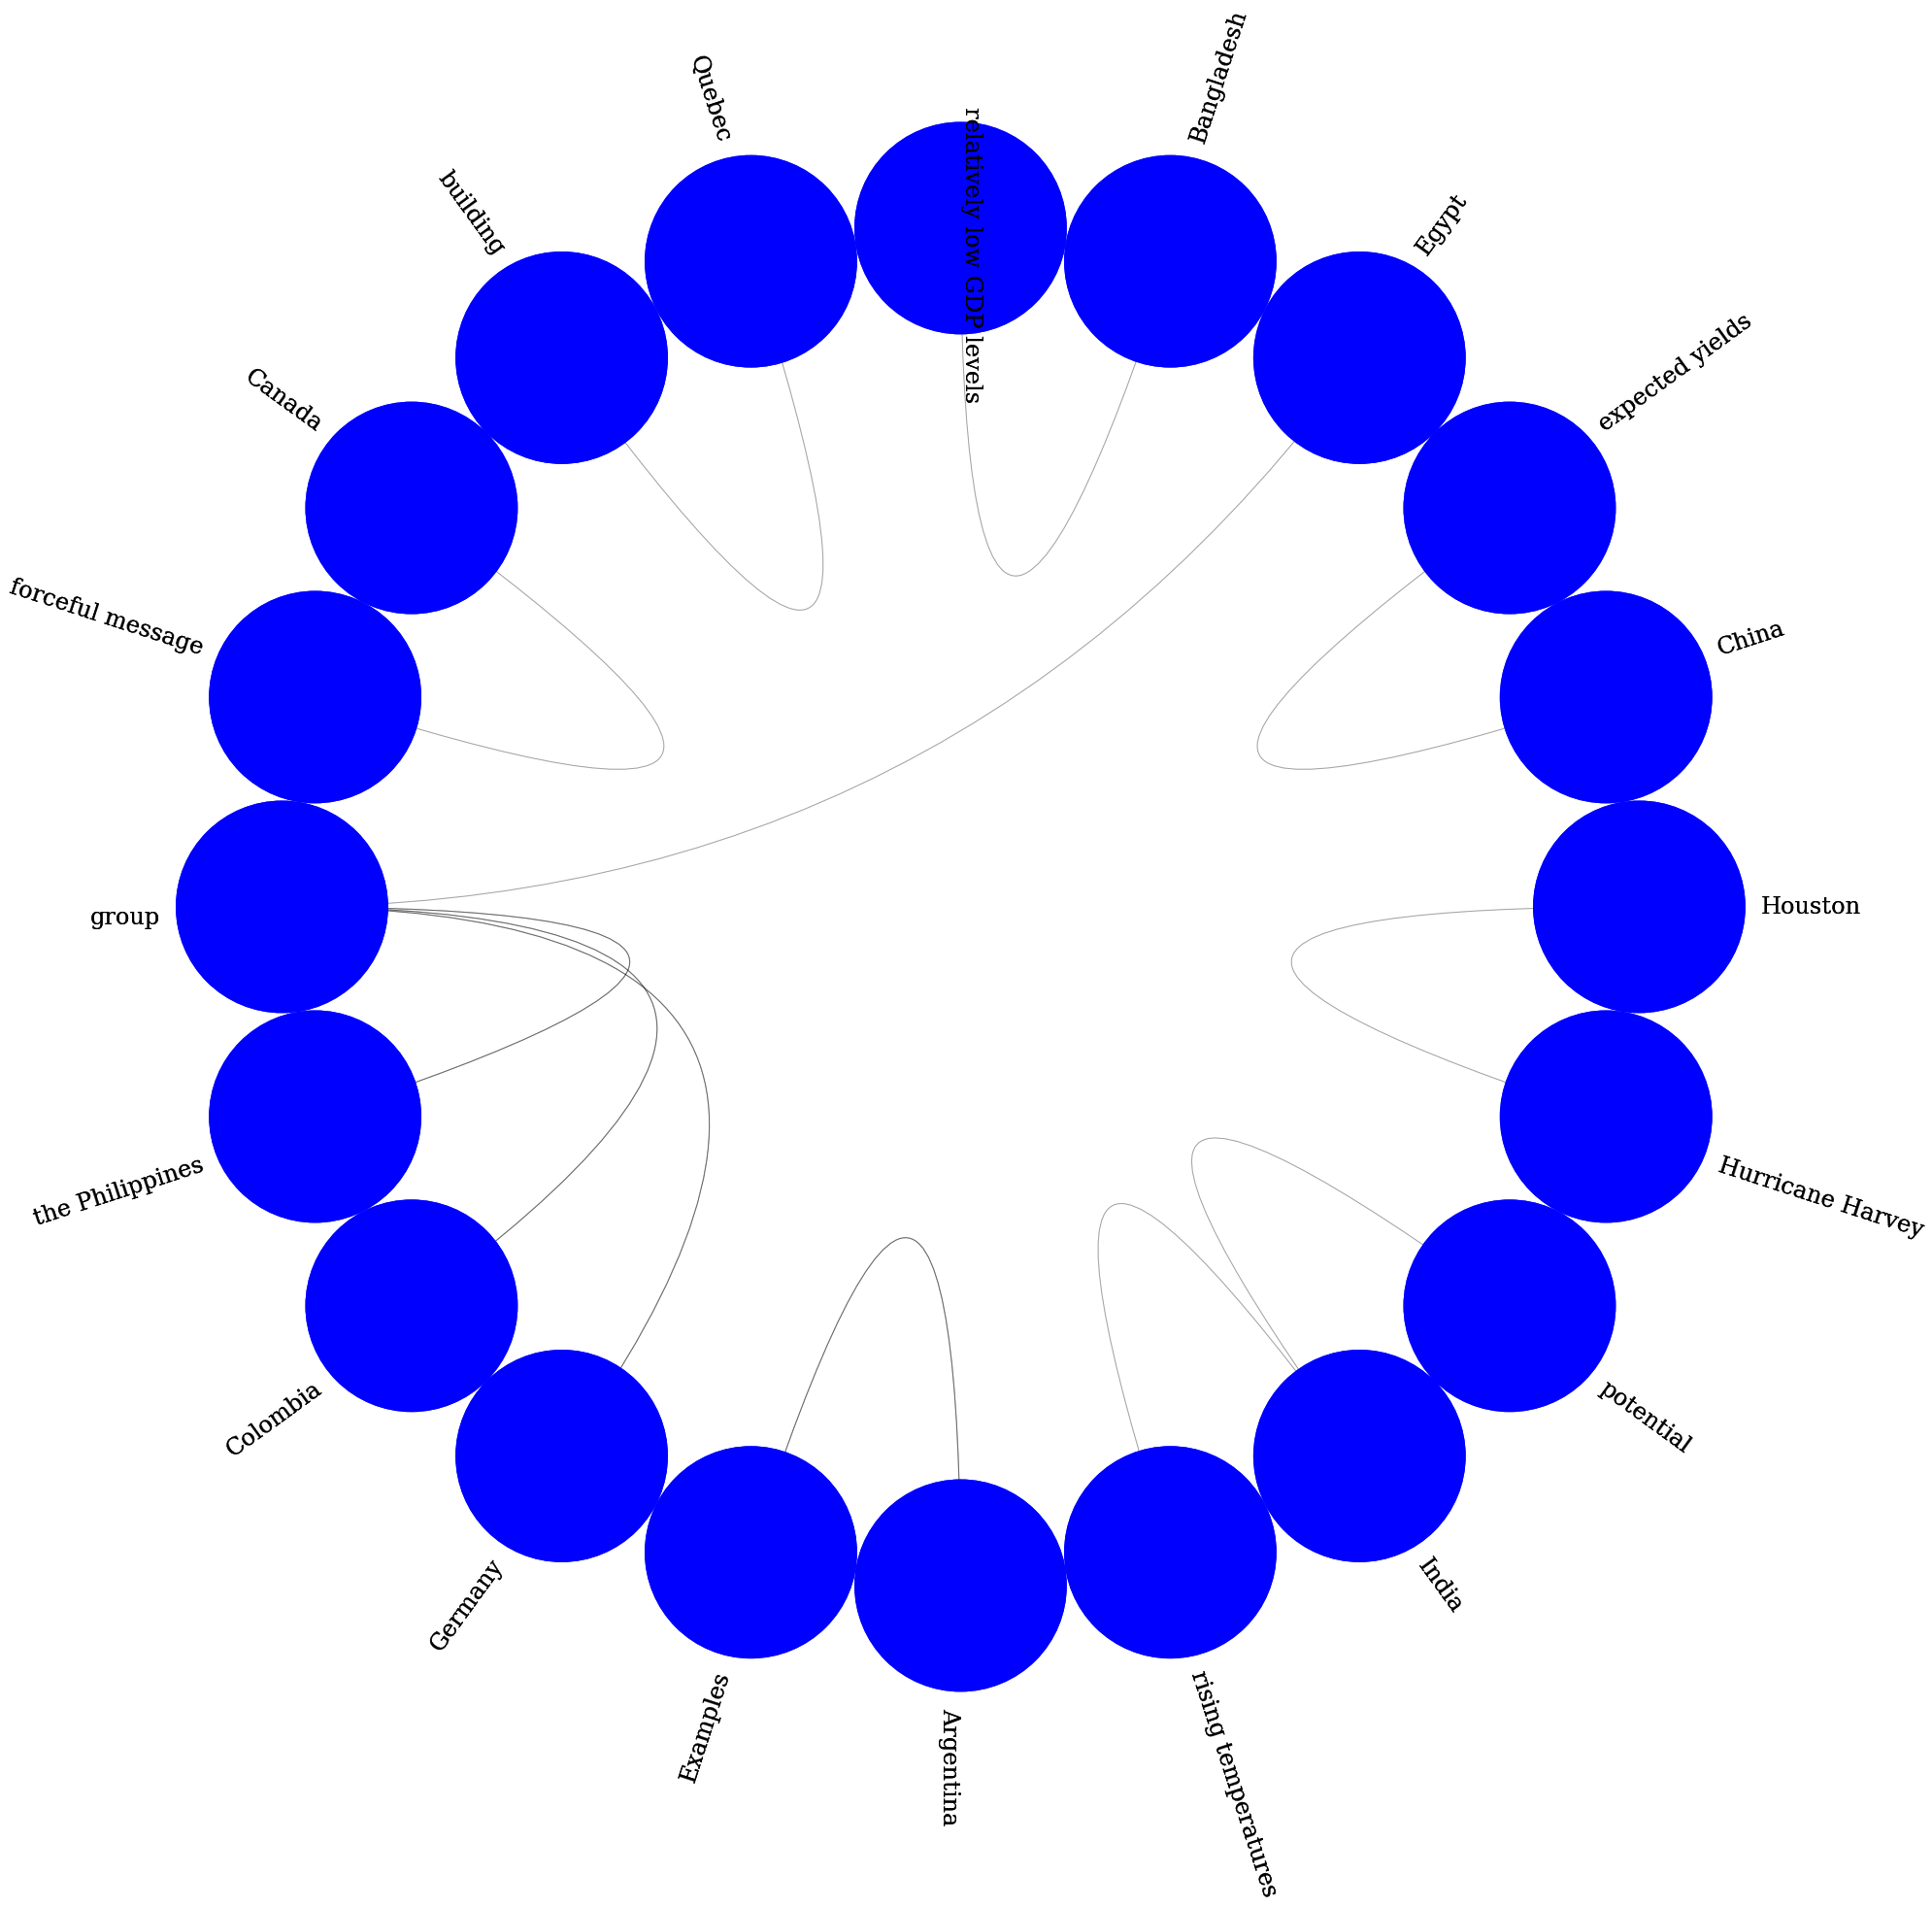

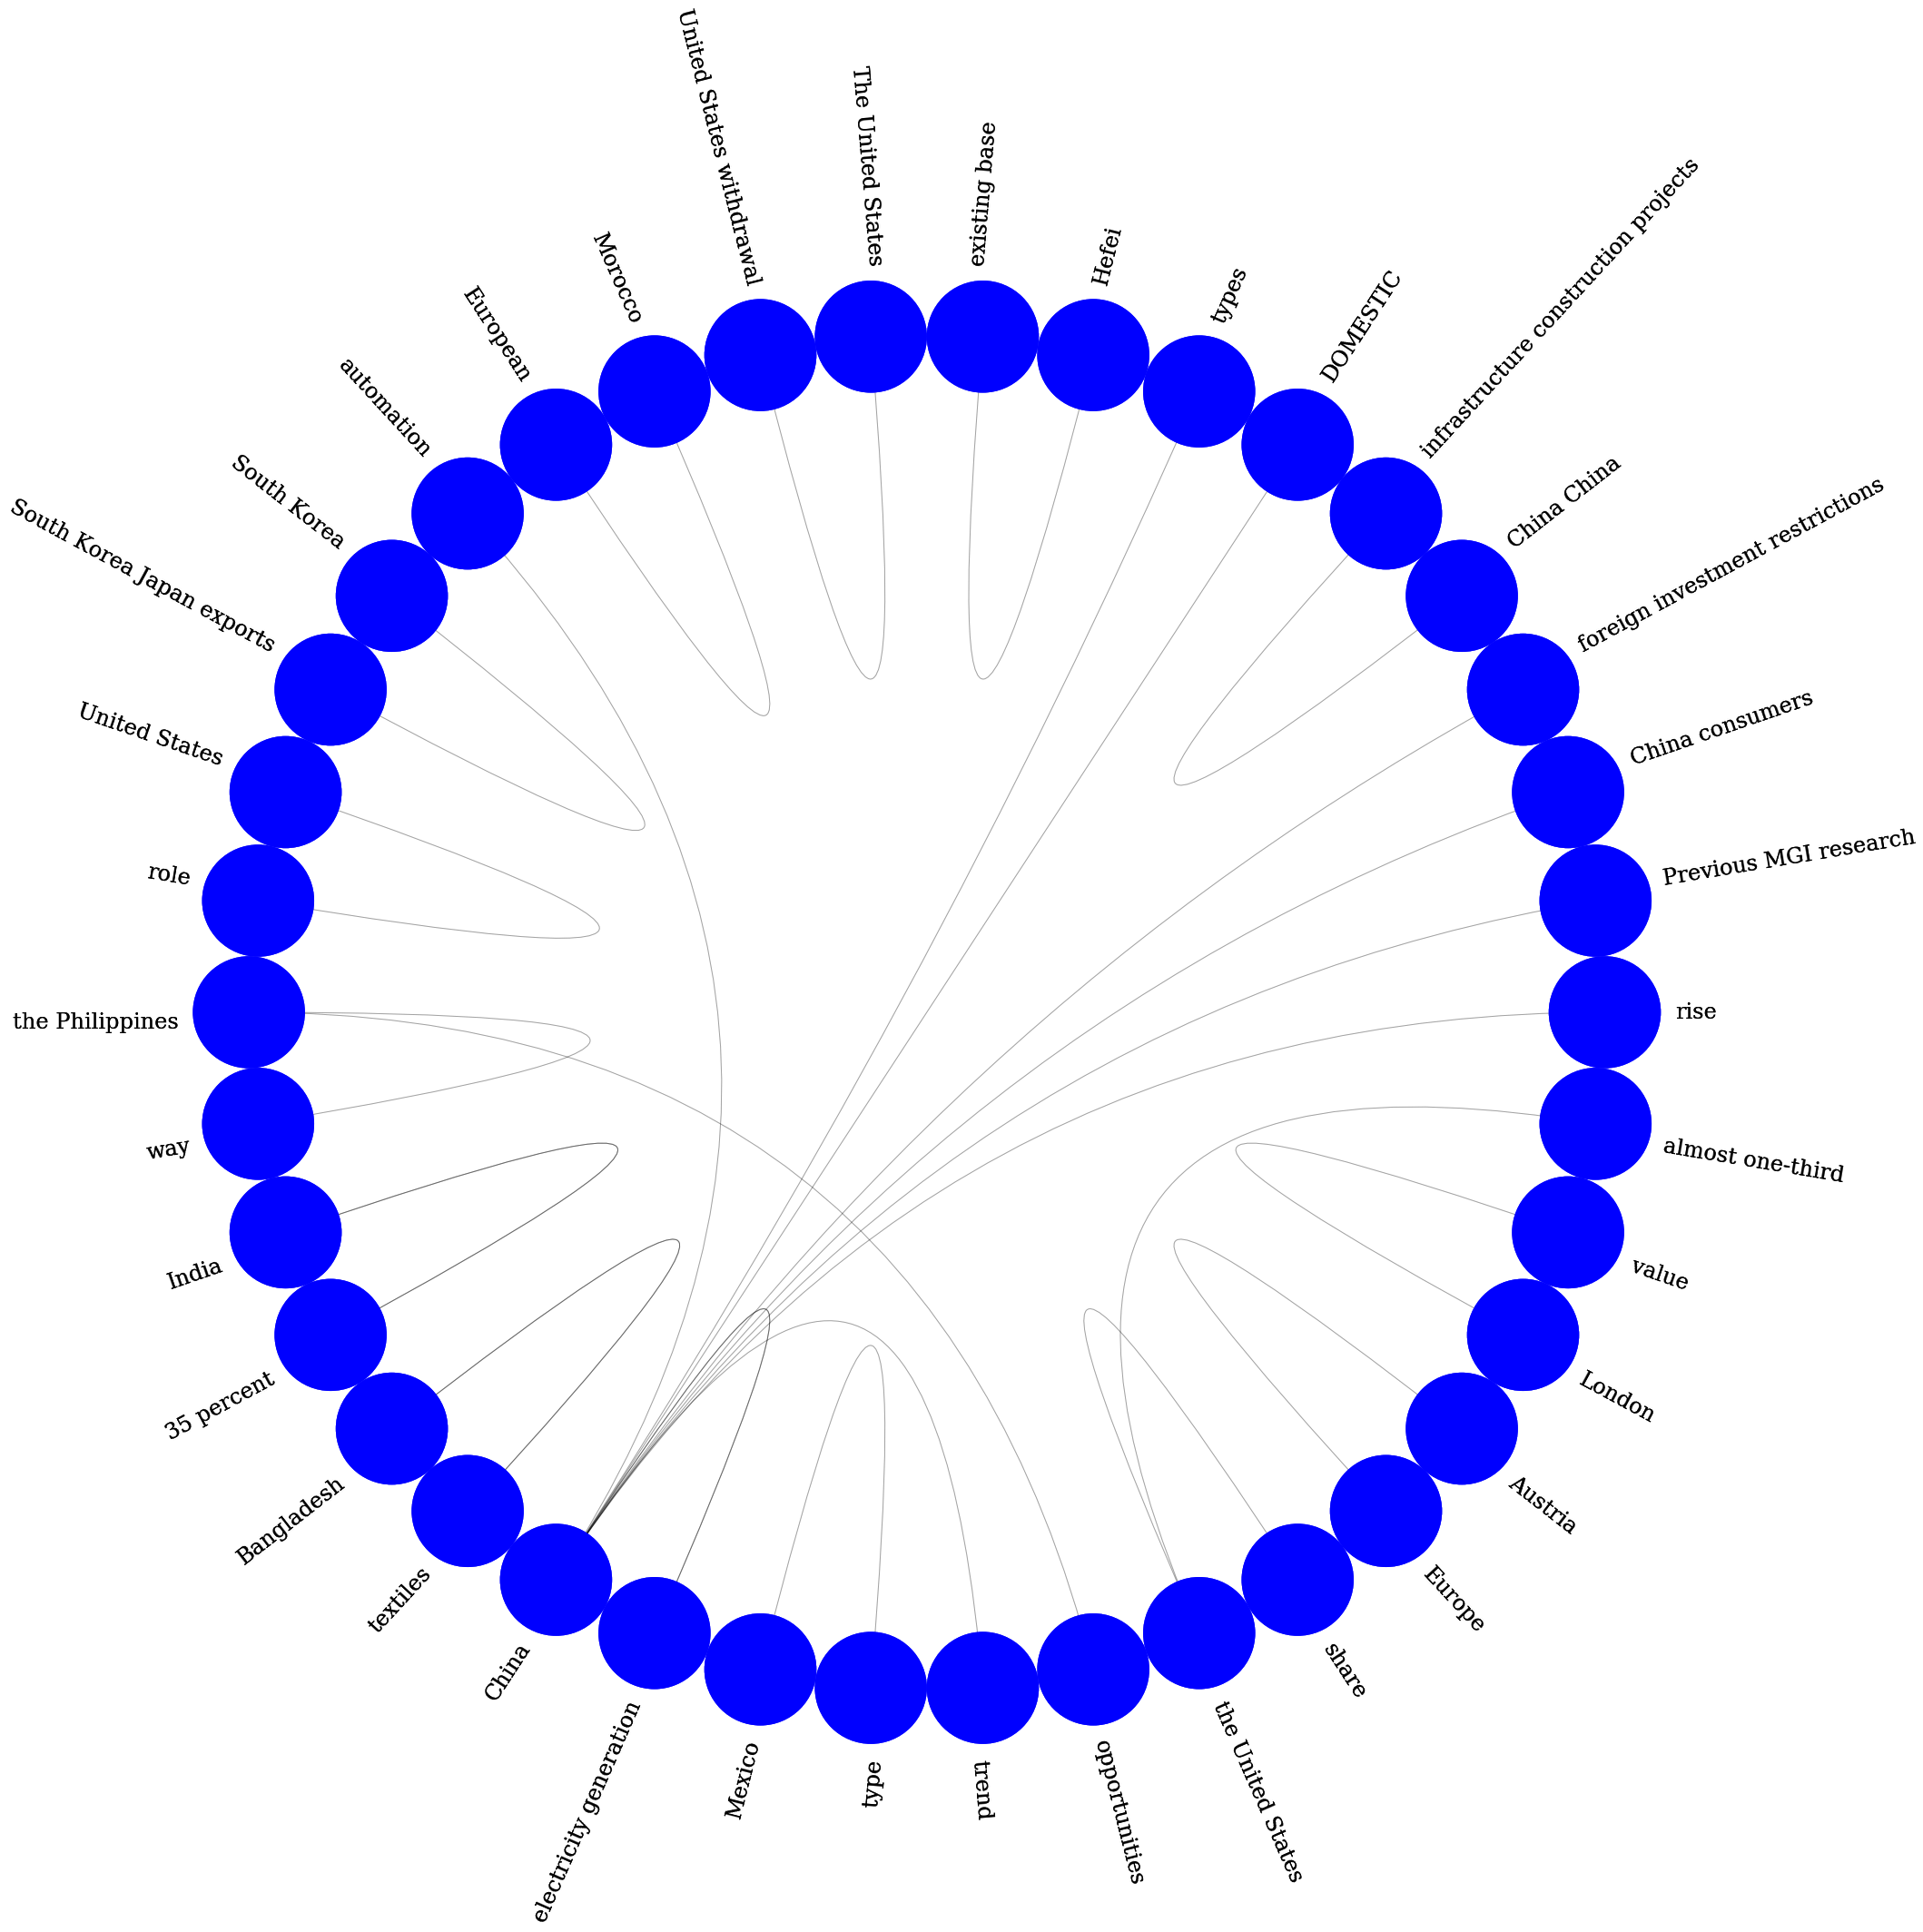

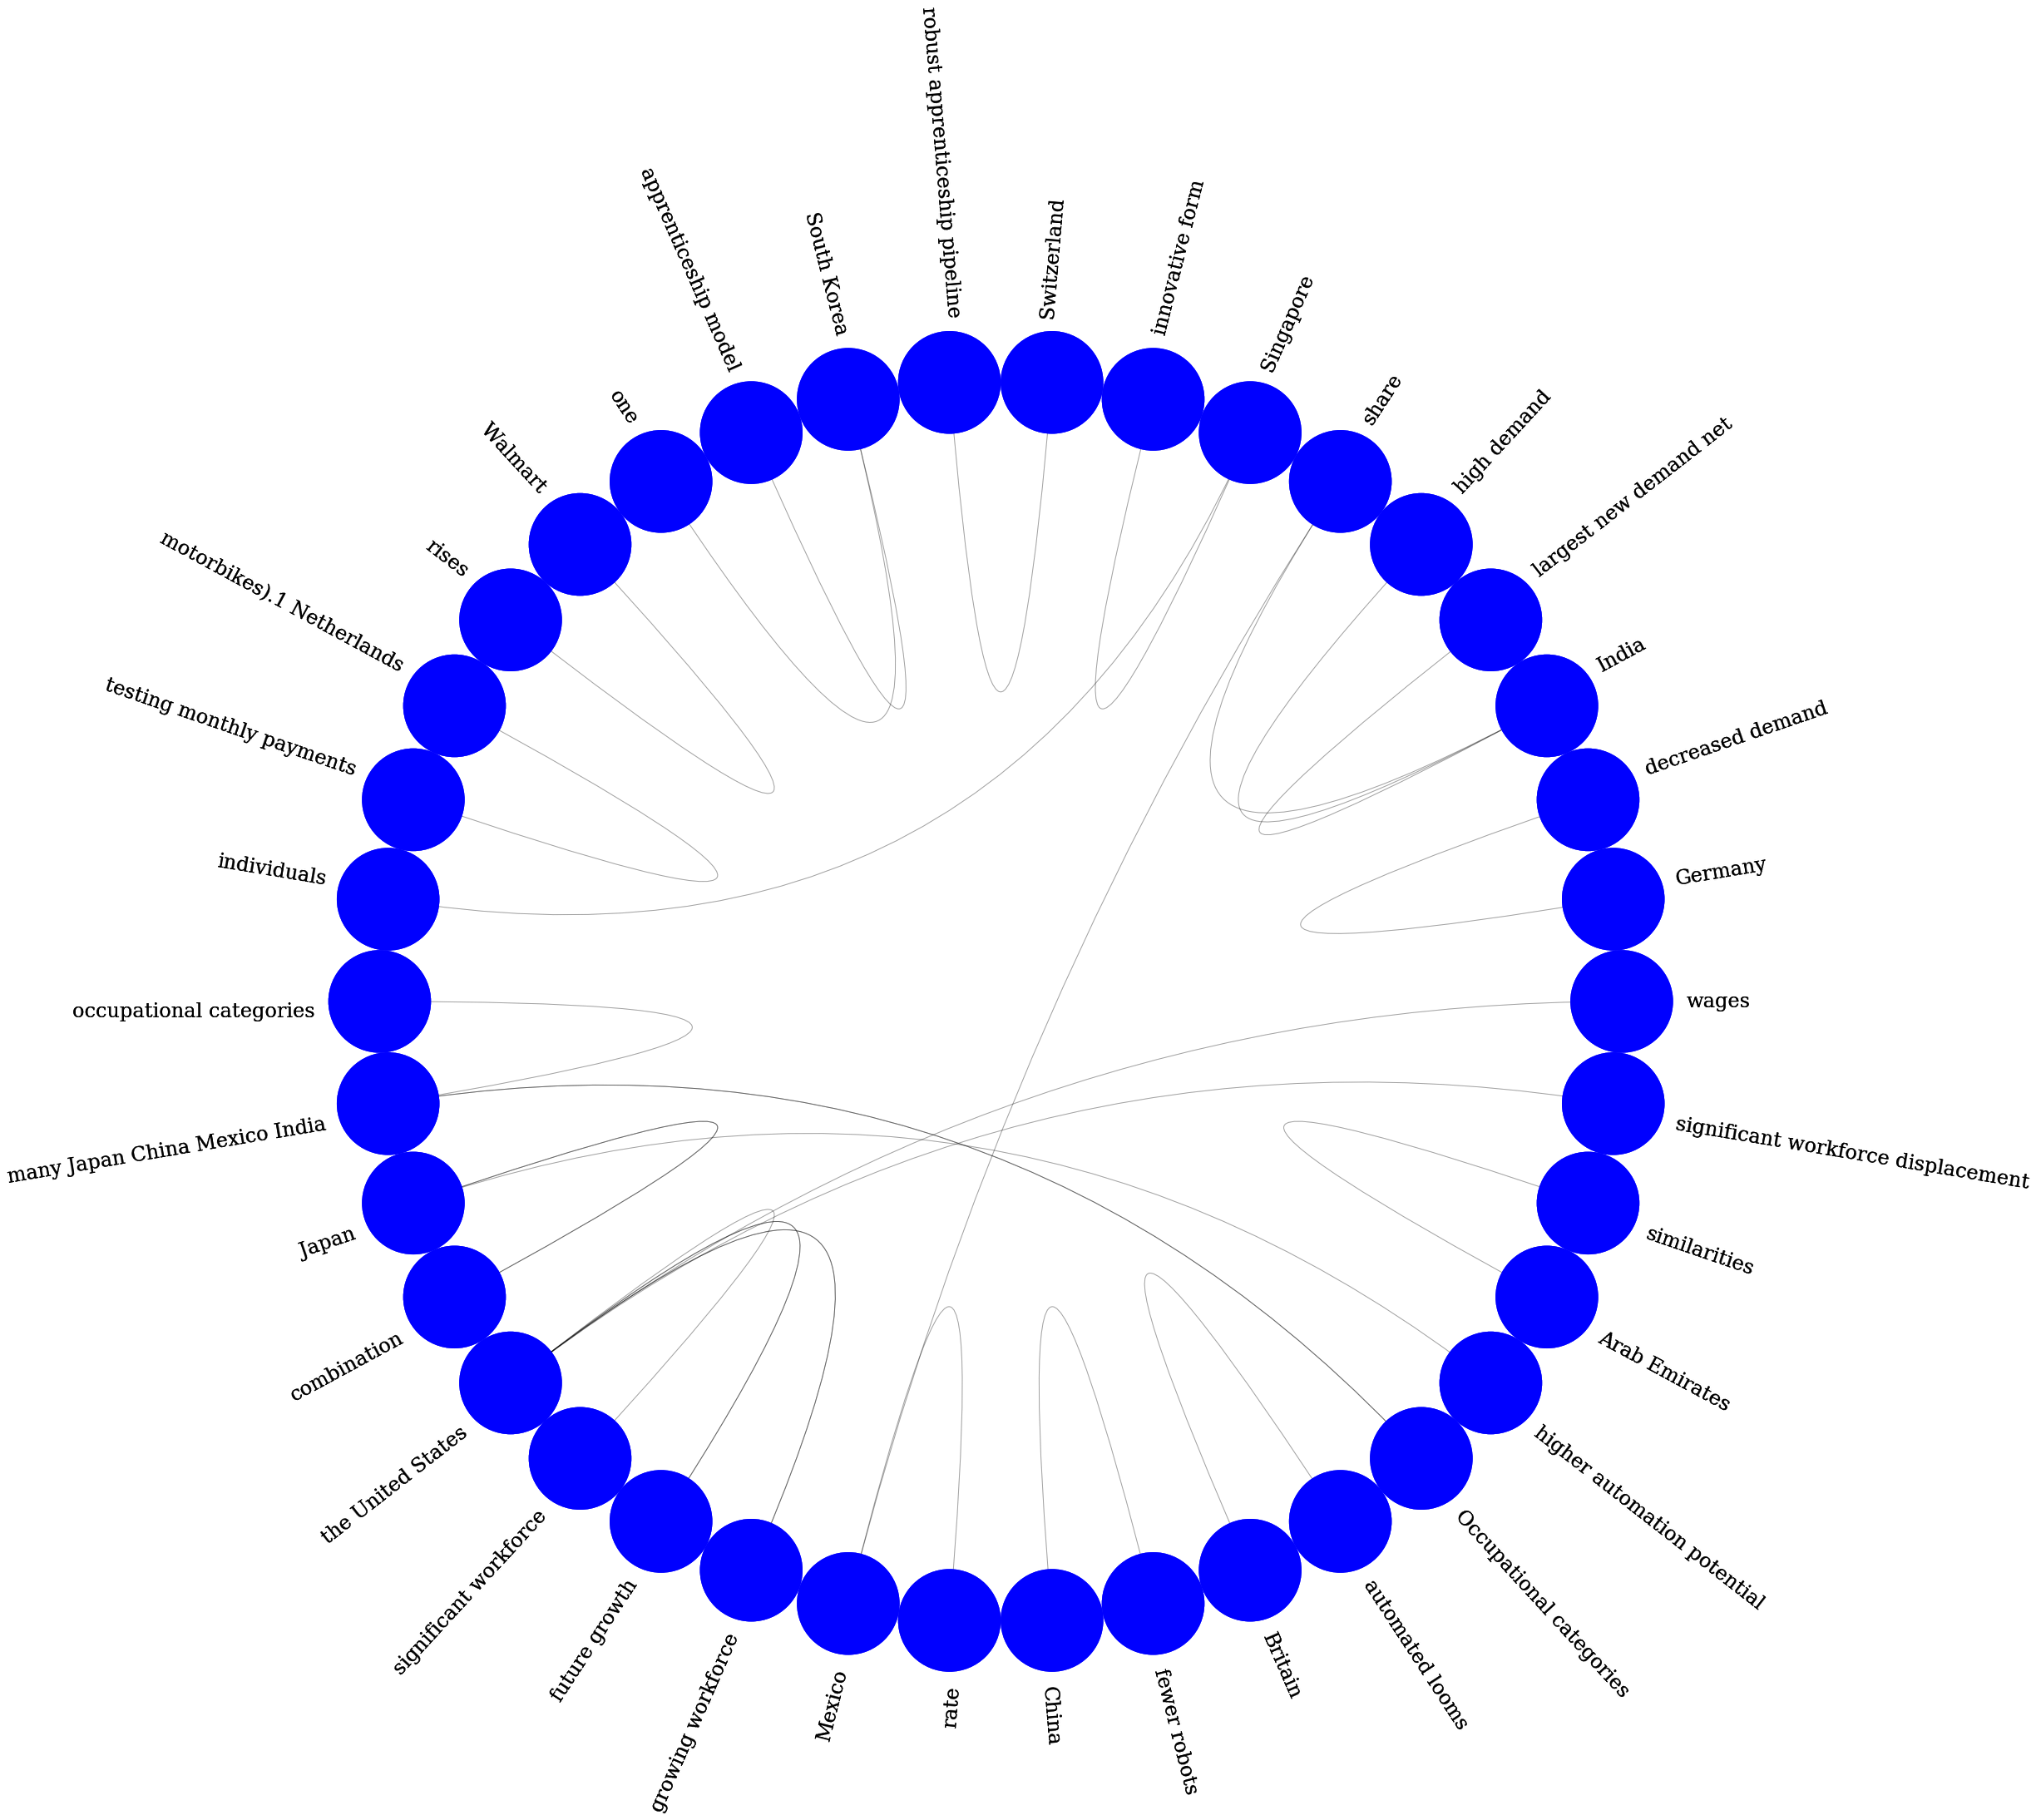

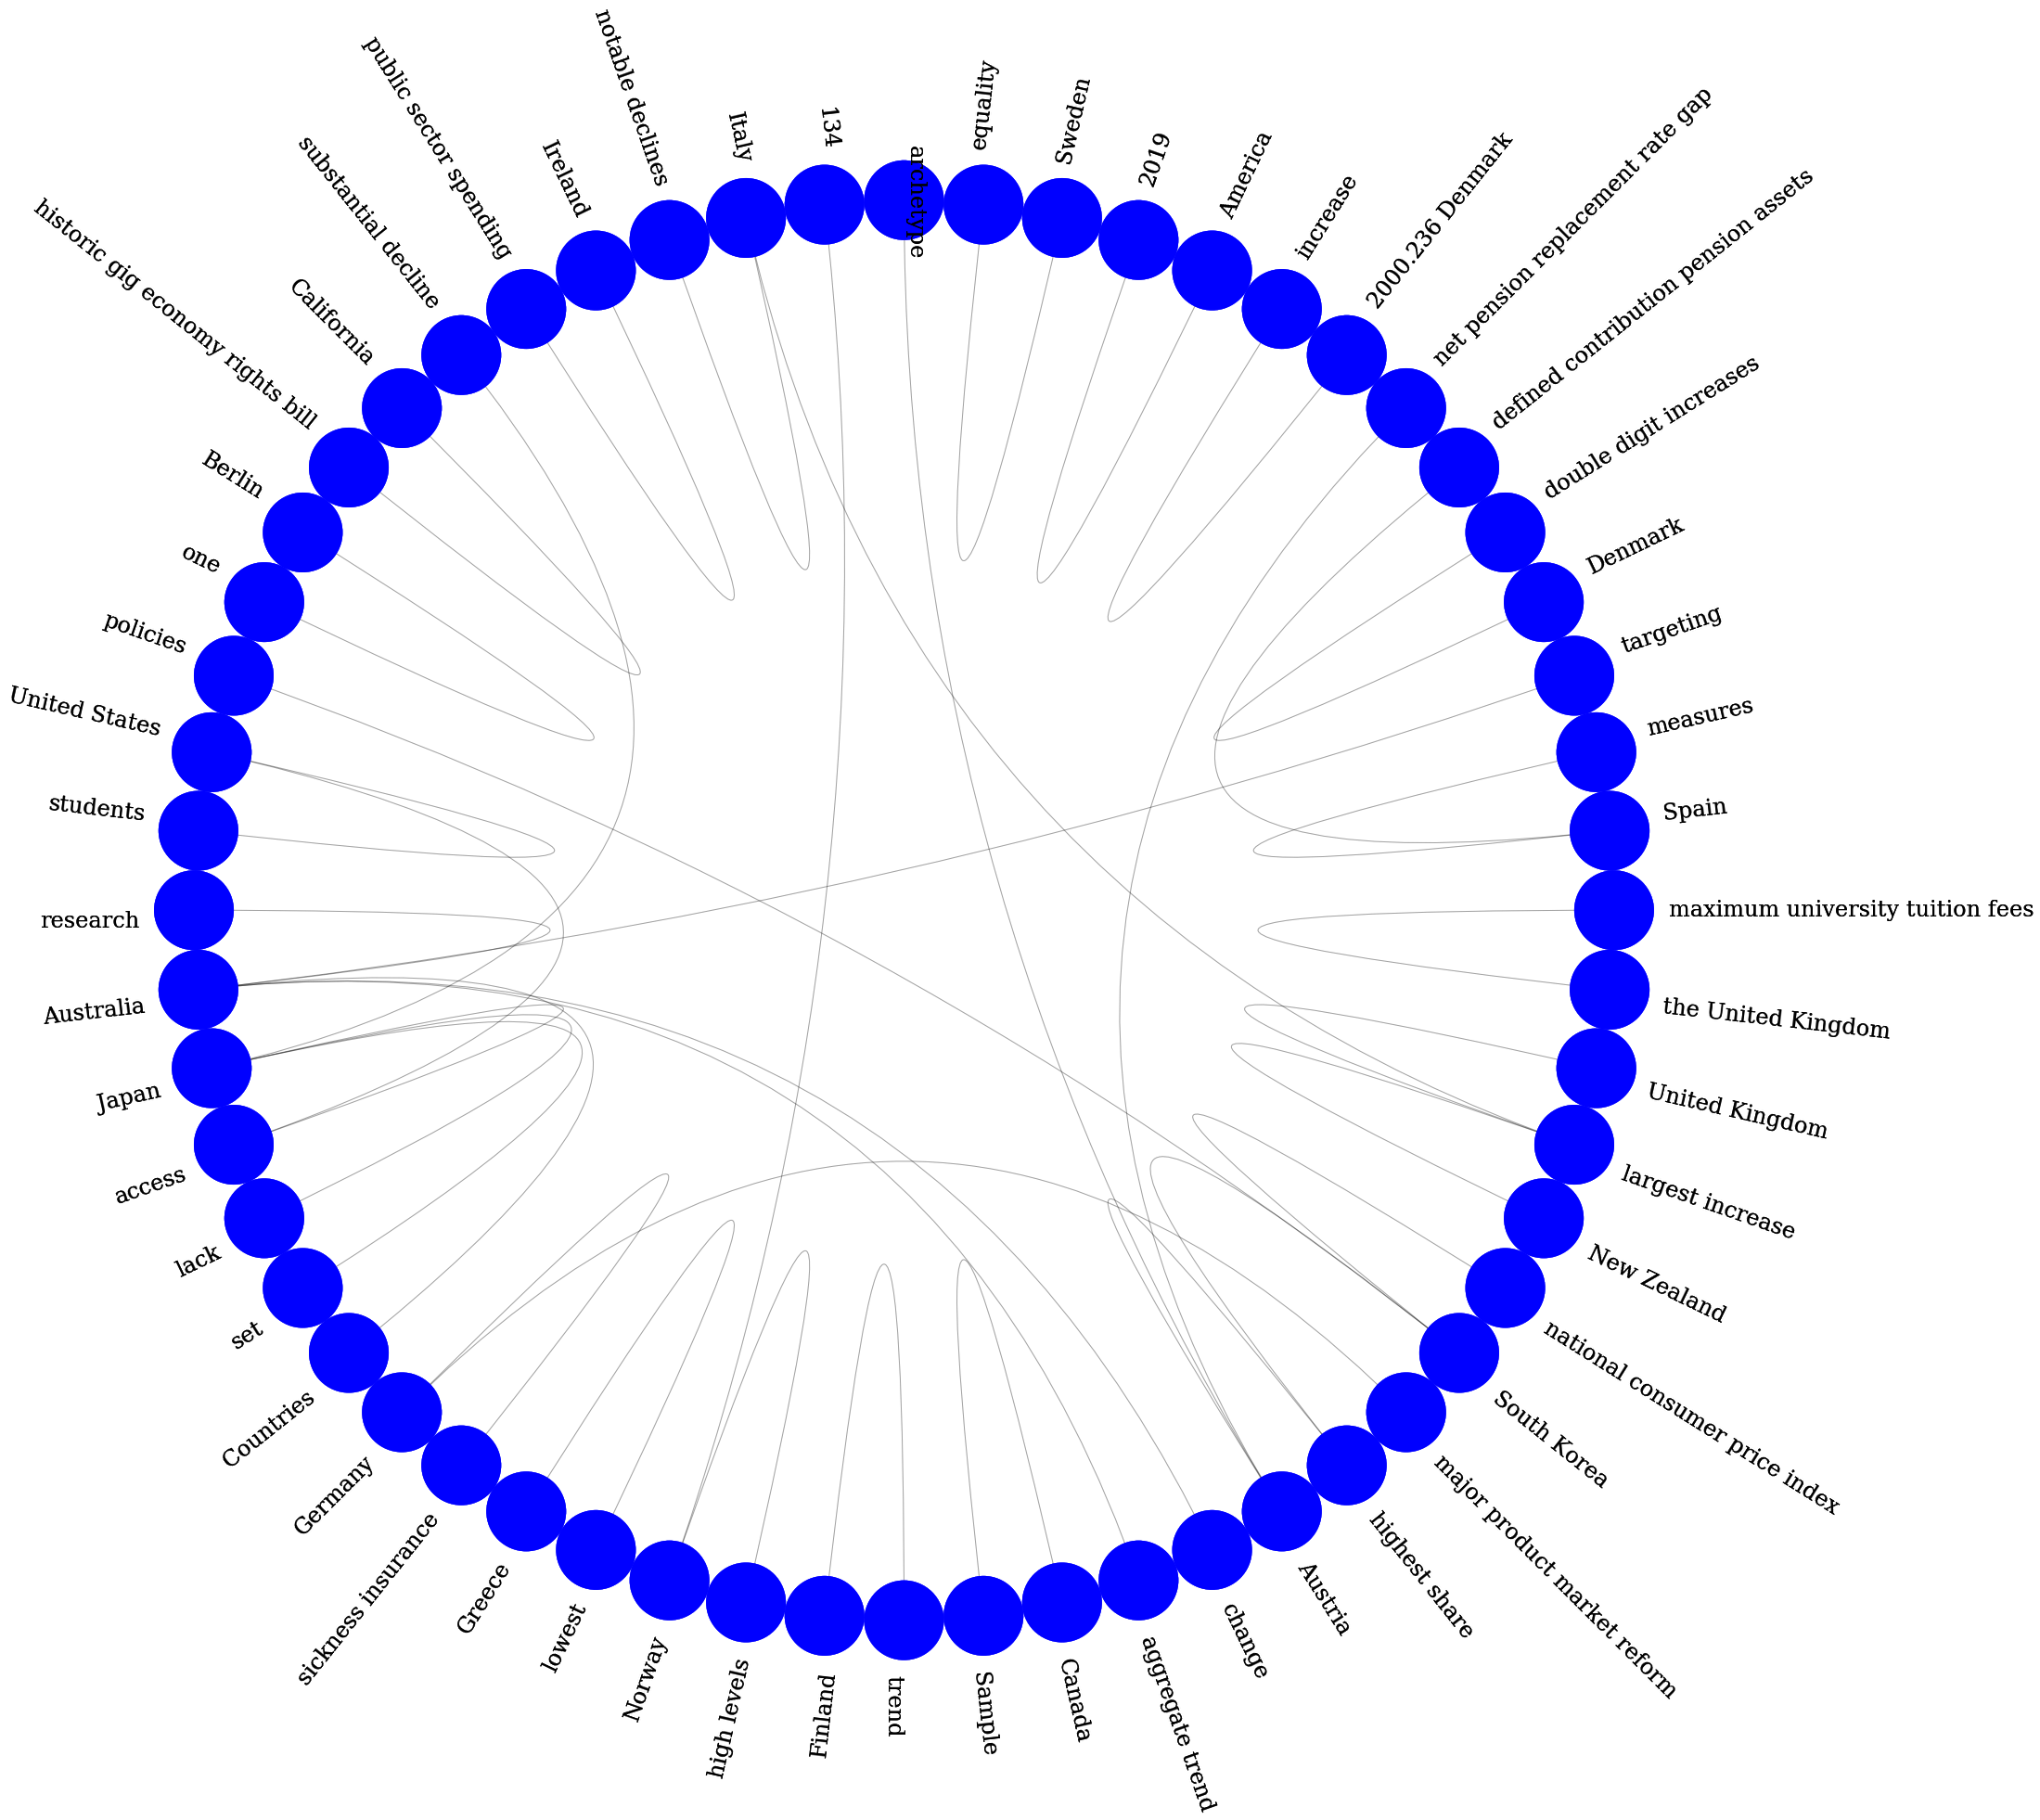

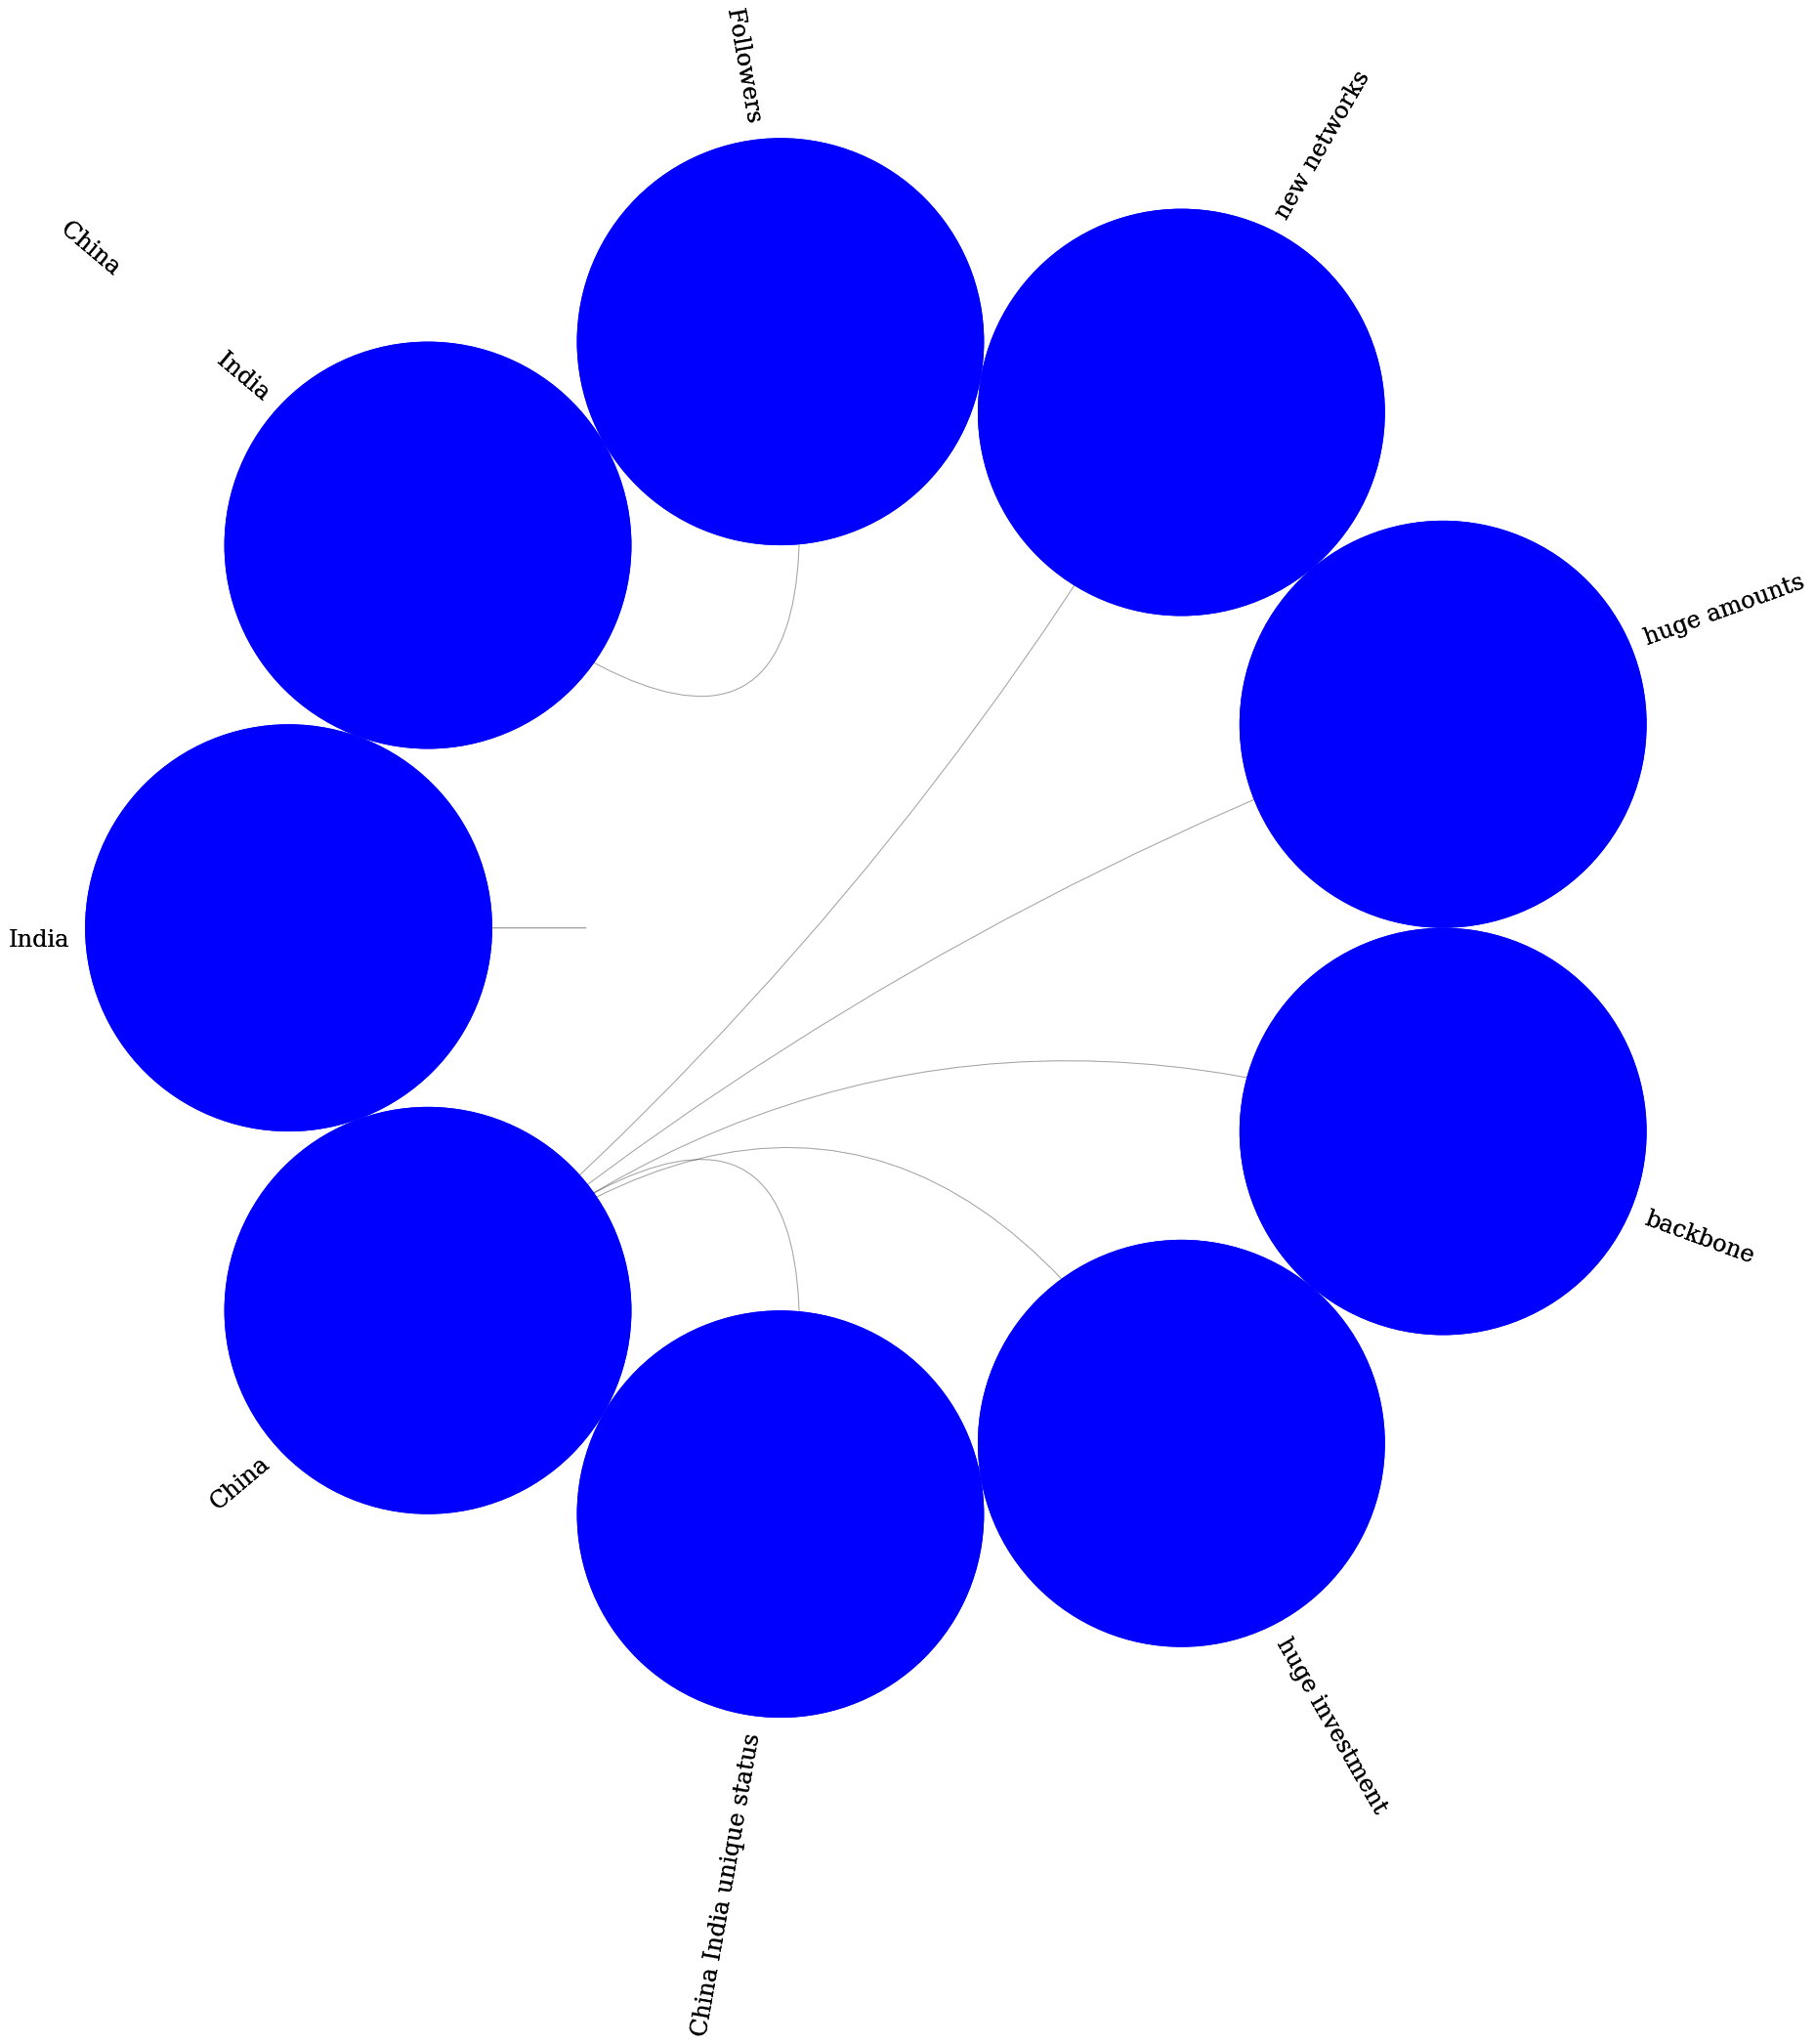

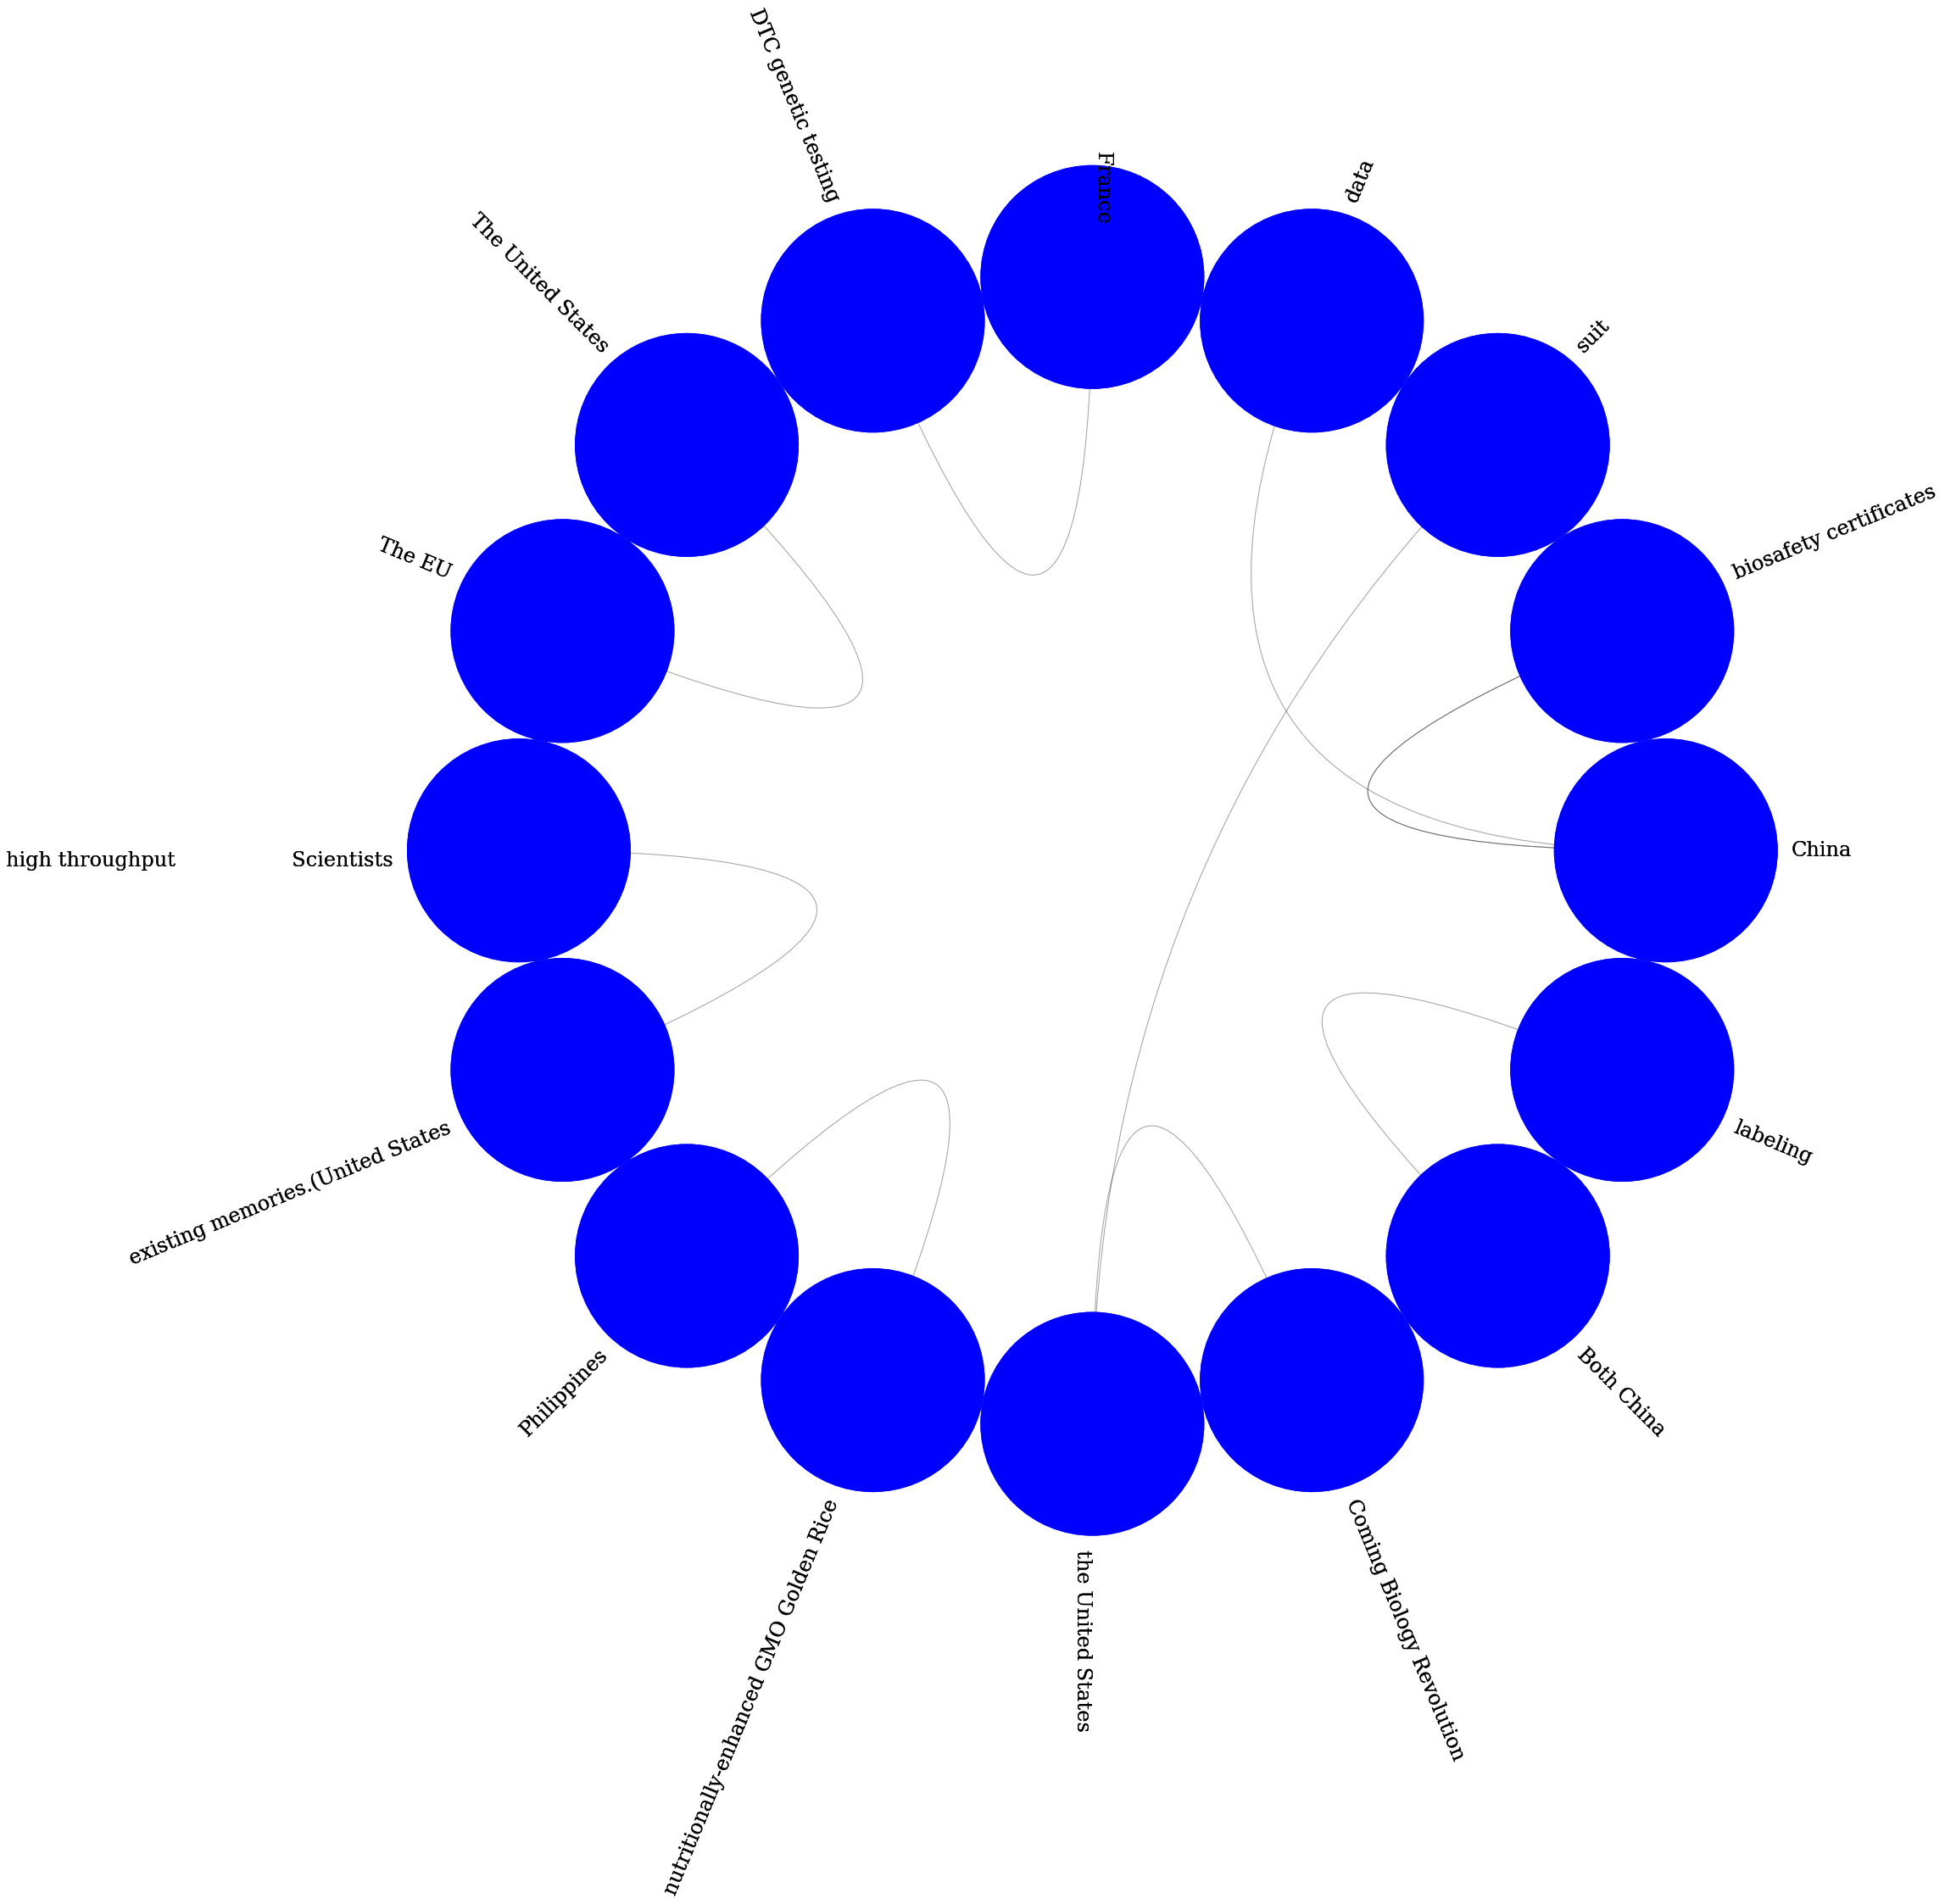

In [17]:
for i in range(len(gpe_list)):
    circos_plot(gpe_list[i])

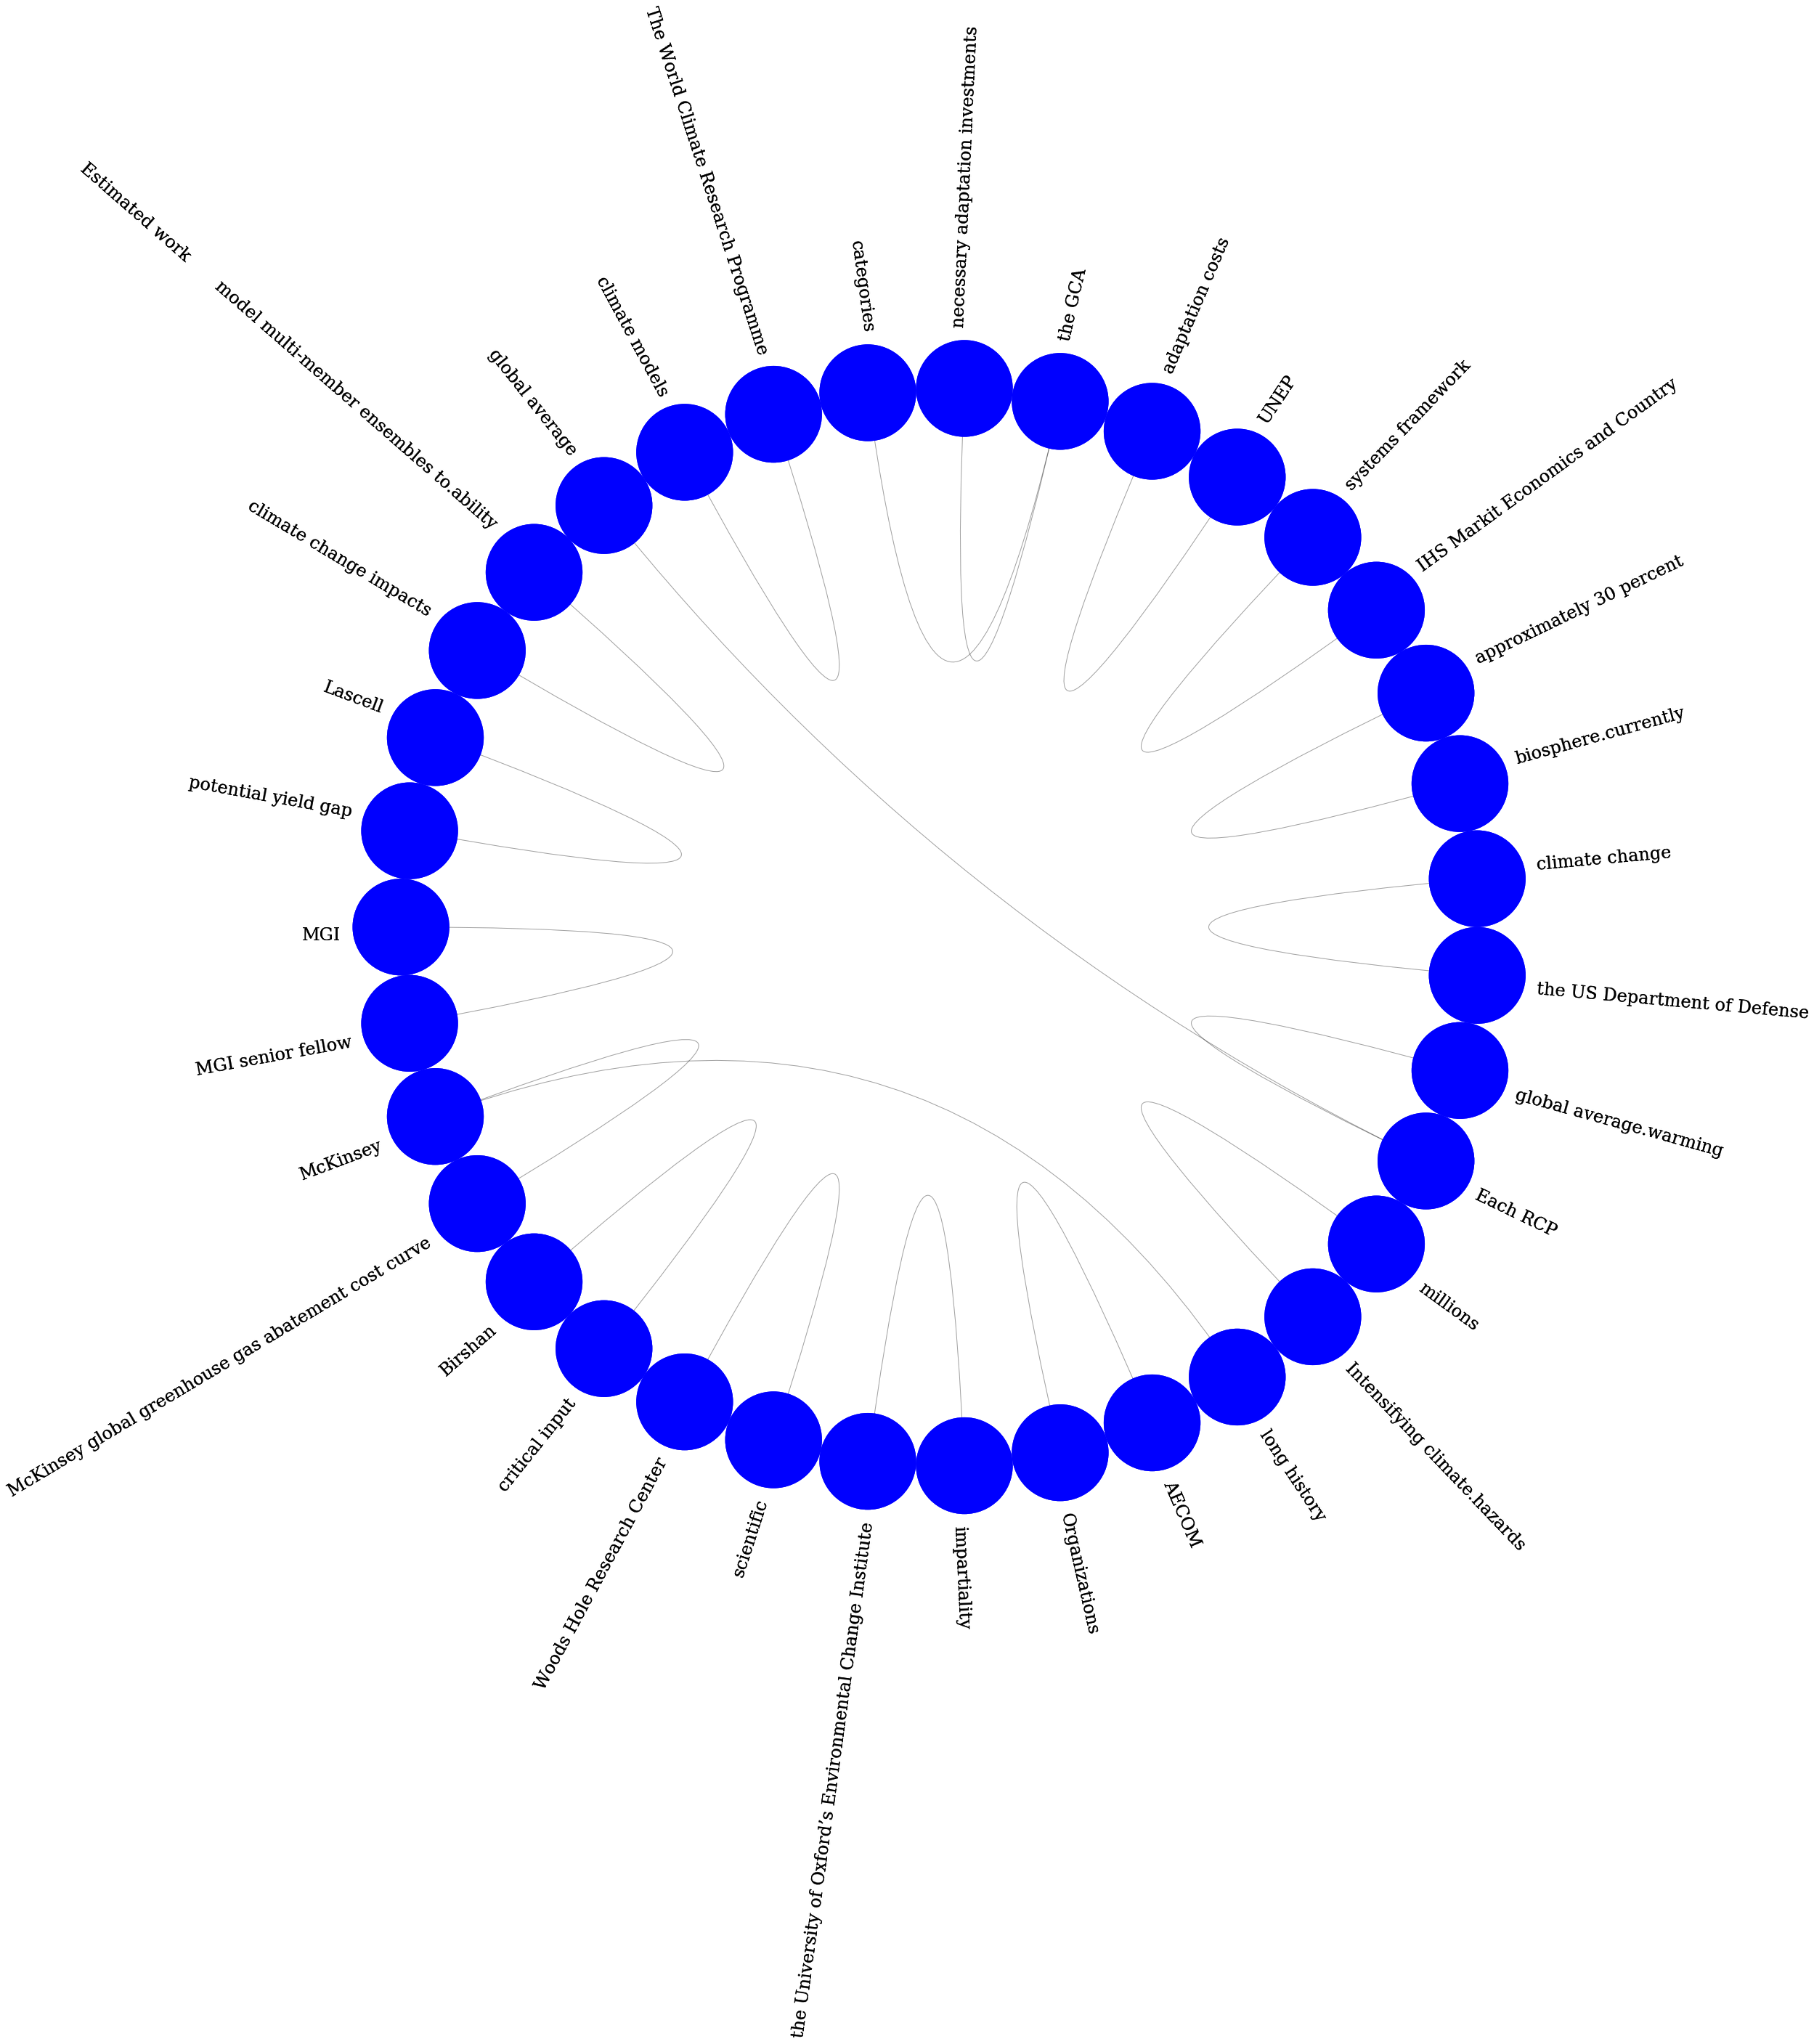

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 61552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 61552 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 61607 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 61607 missing from current font.
  font.set_text(s, 0, flags=flags)


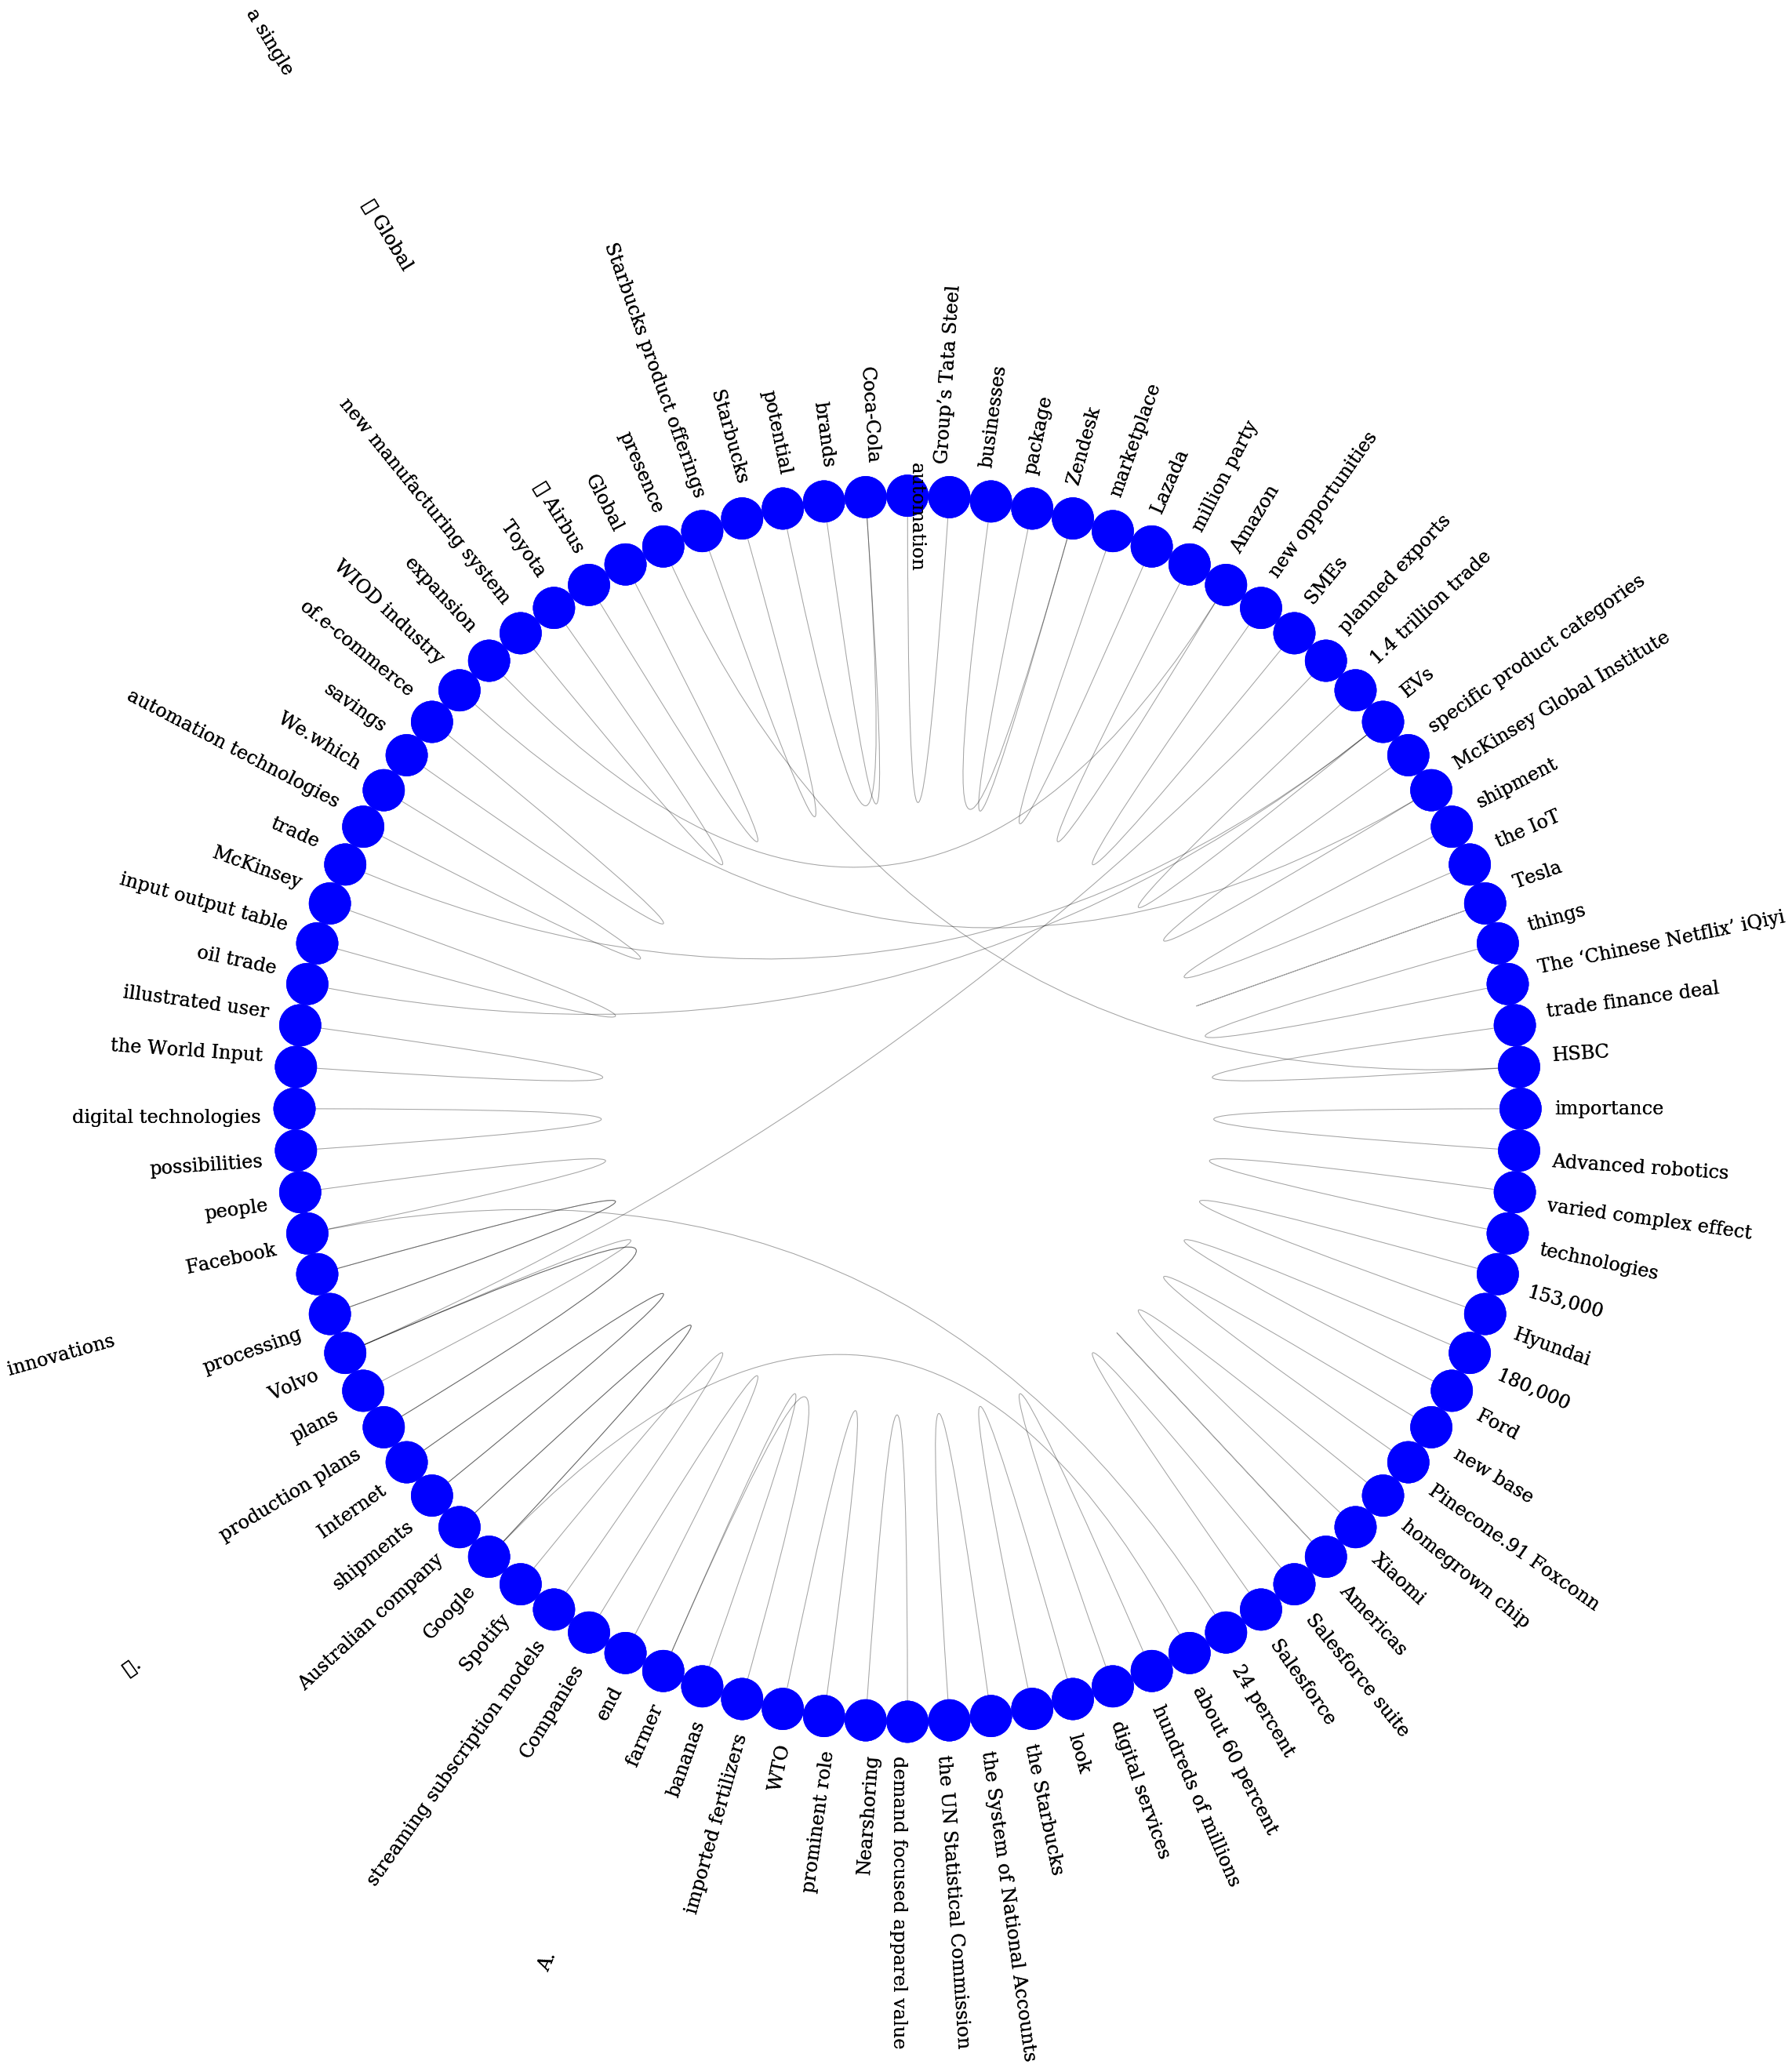

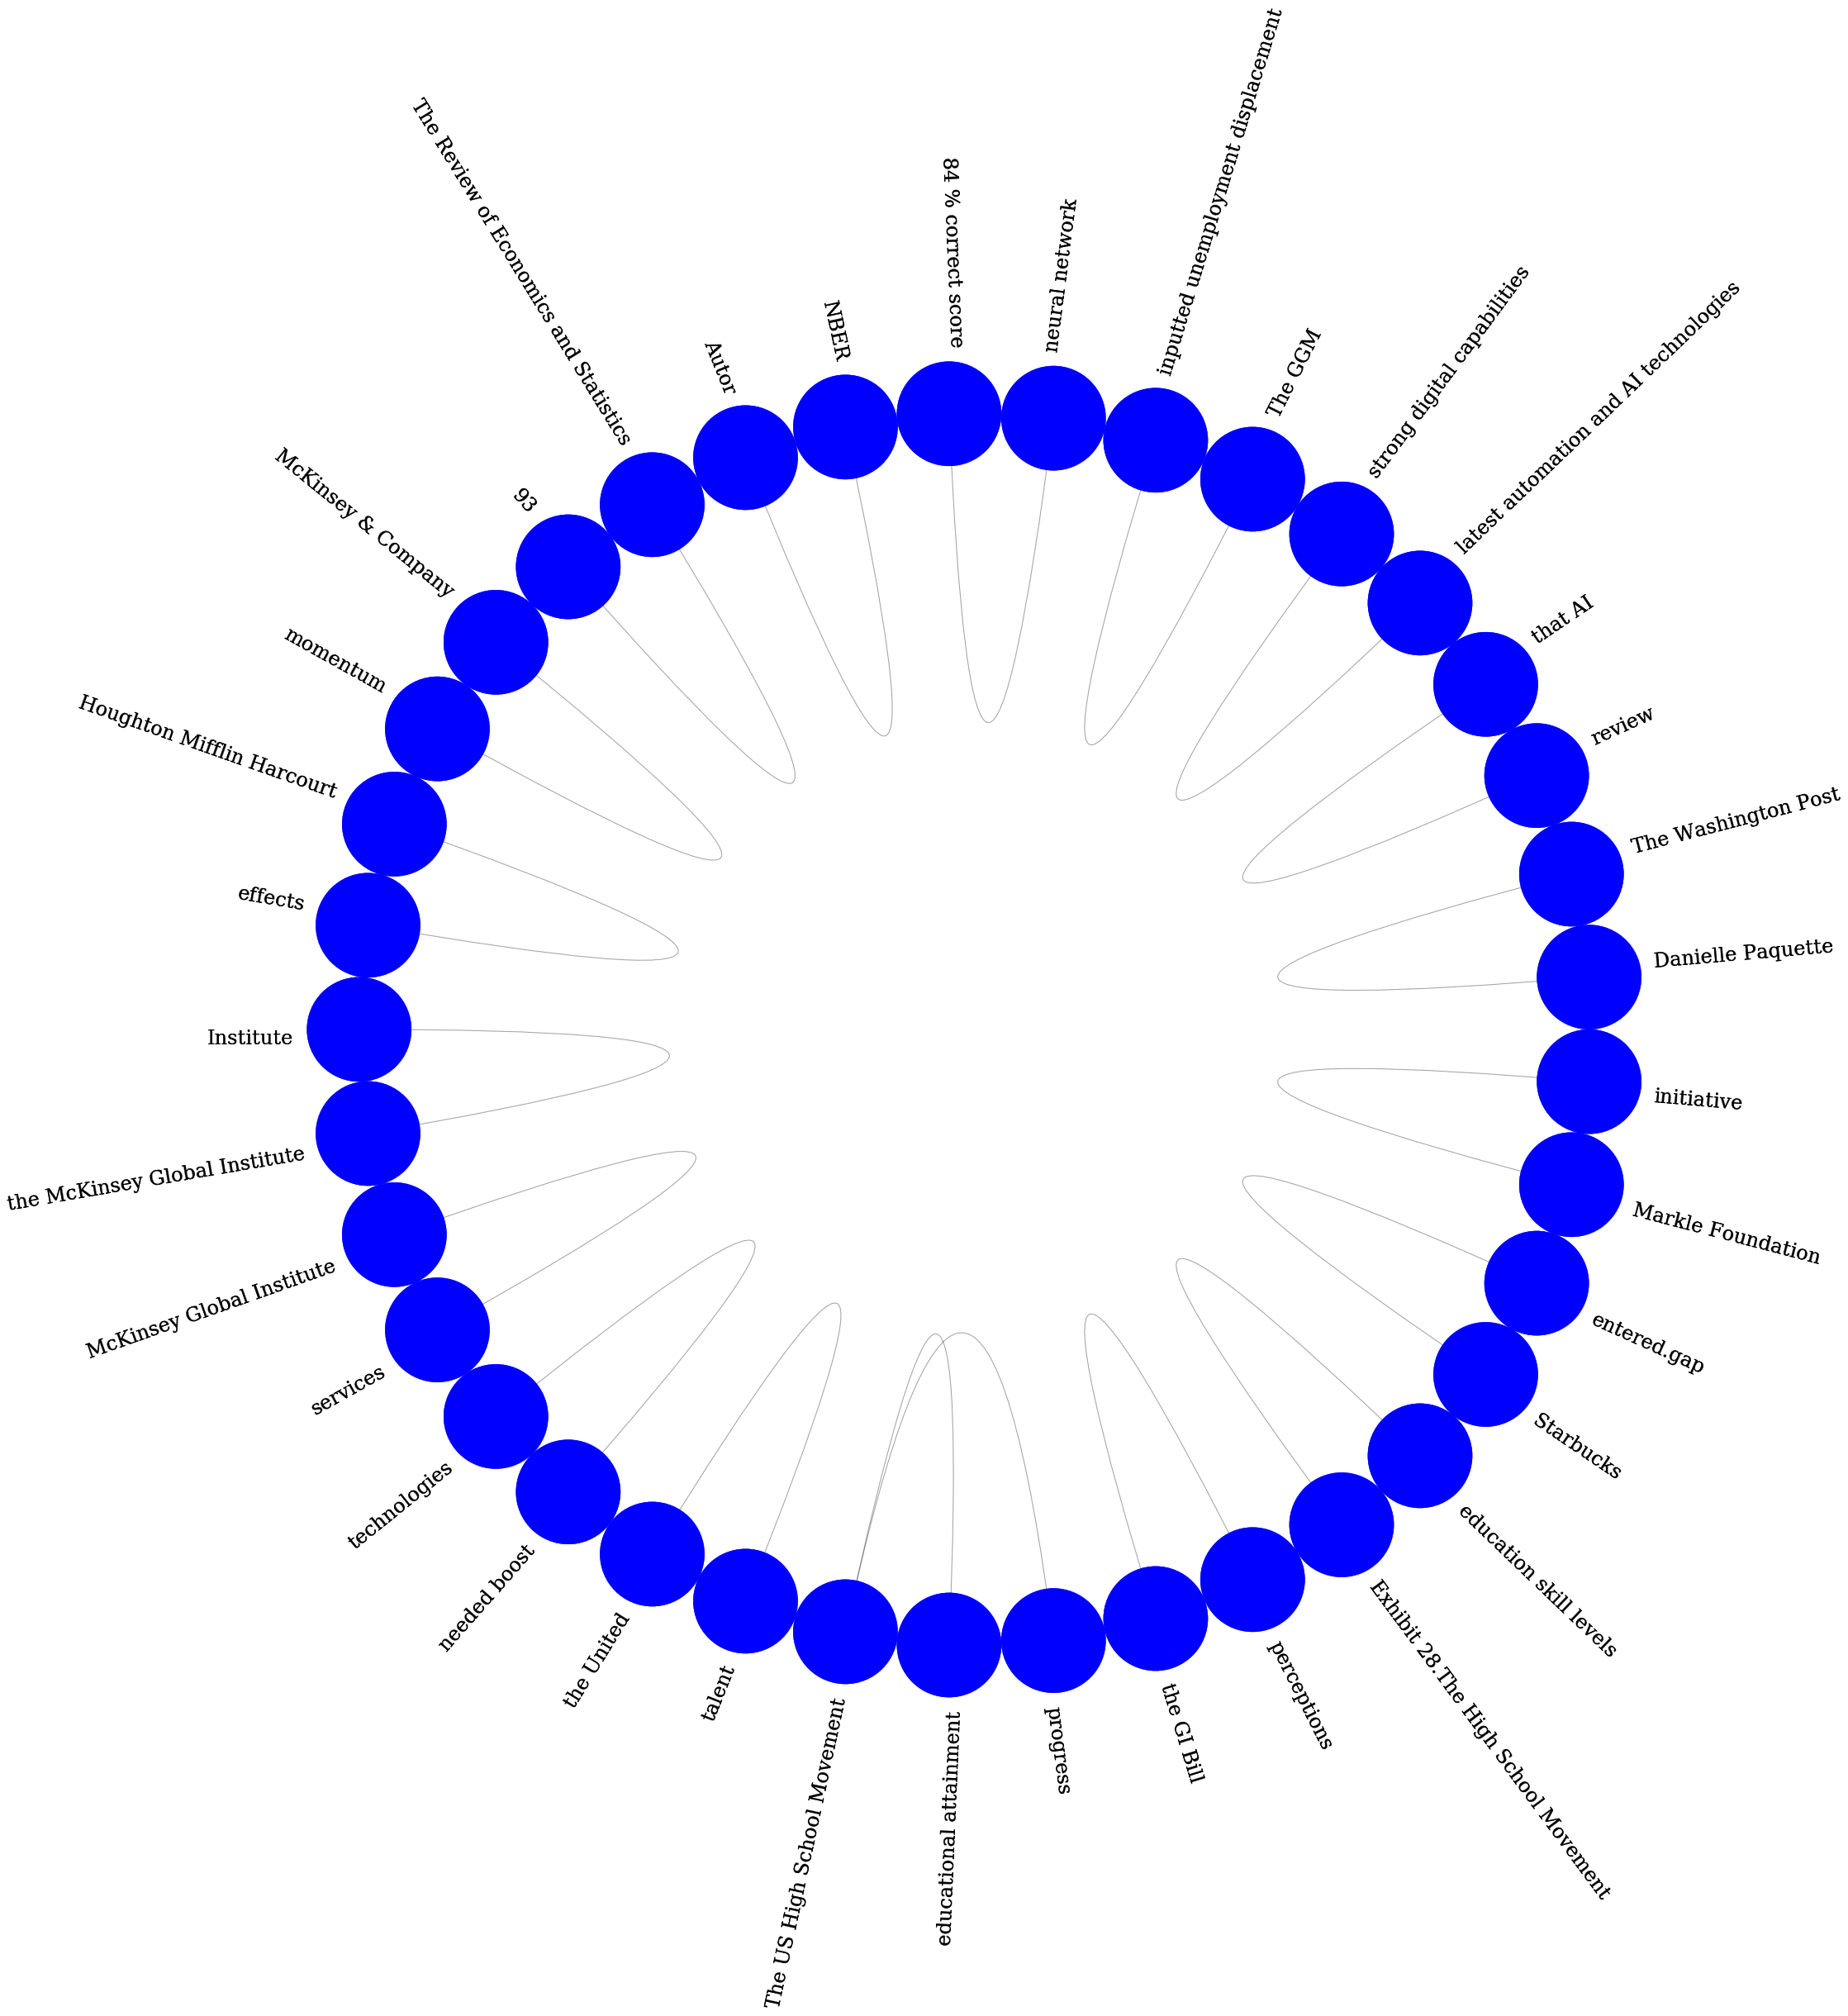

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 61599 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 61599 missing from current font.
  font.set_text(s, 0, flags=flags)


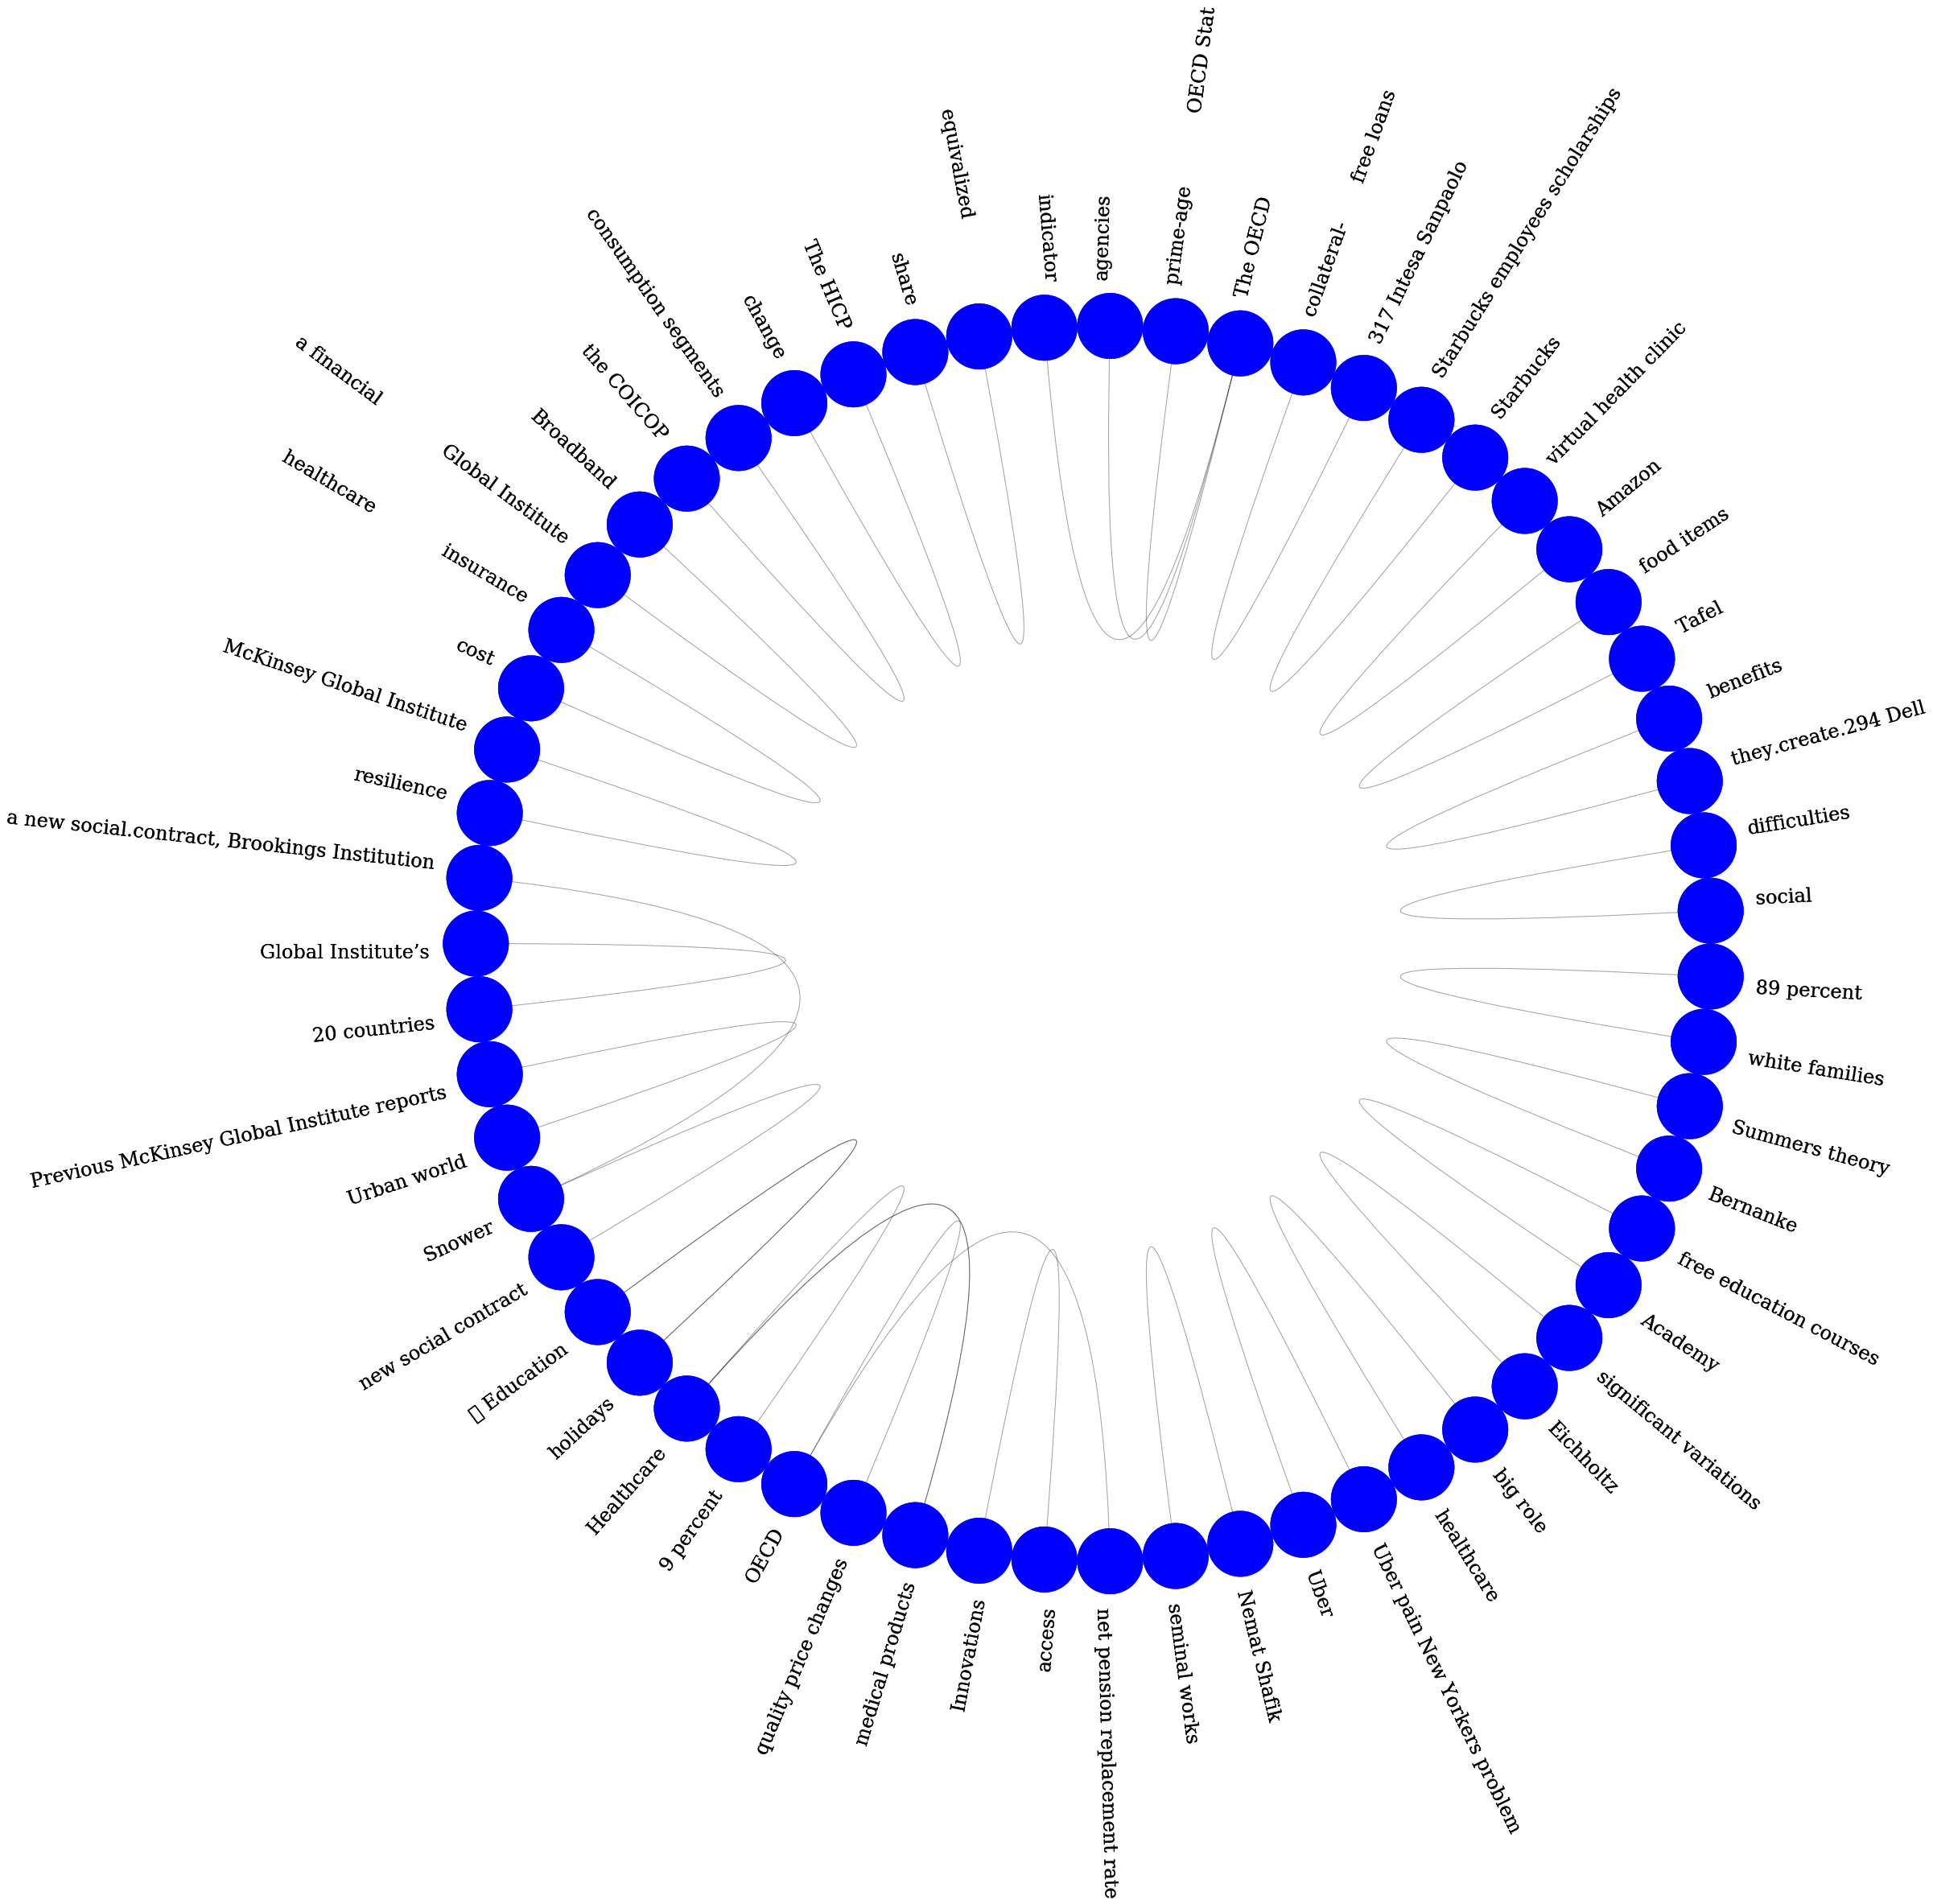

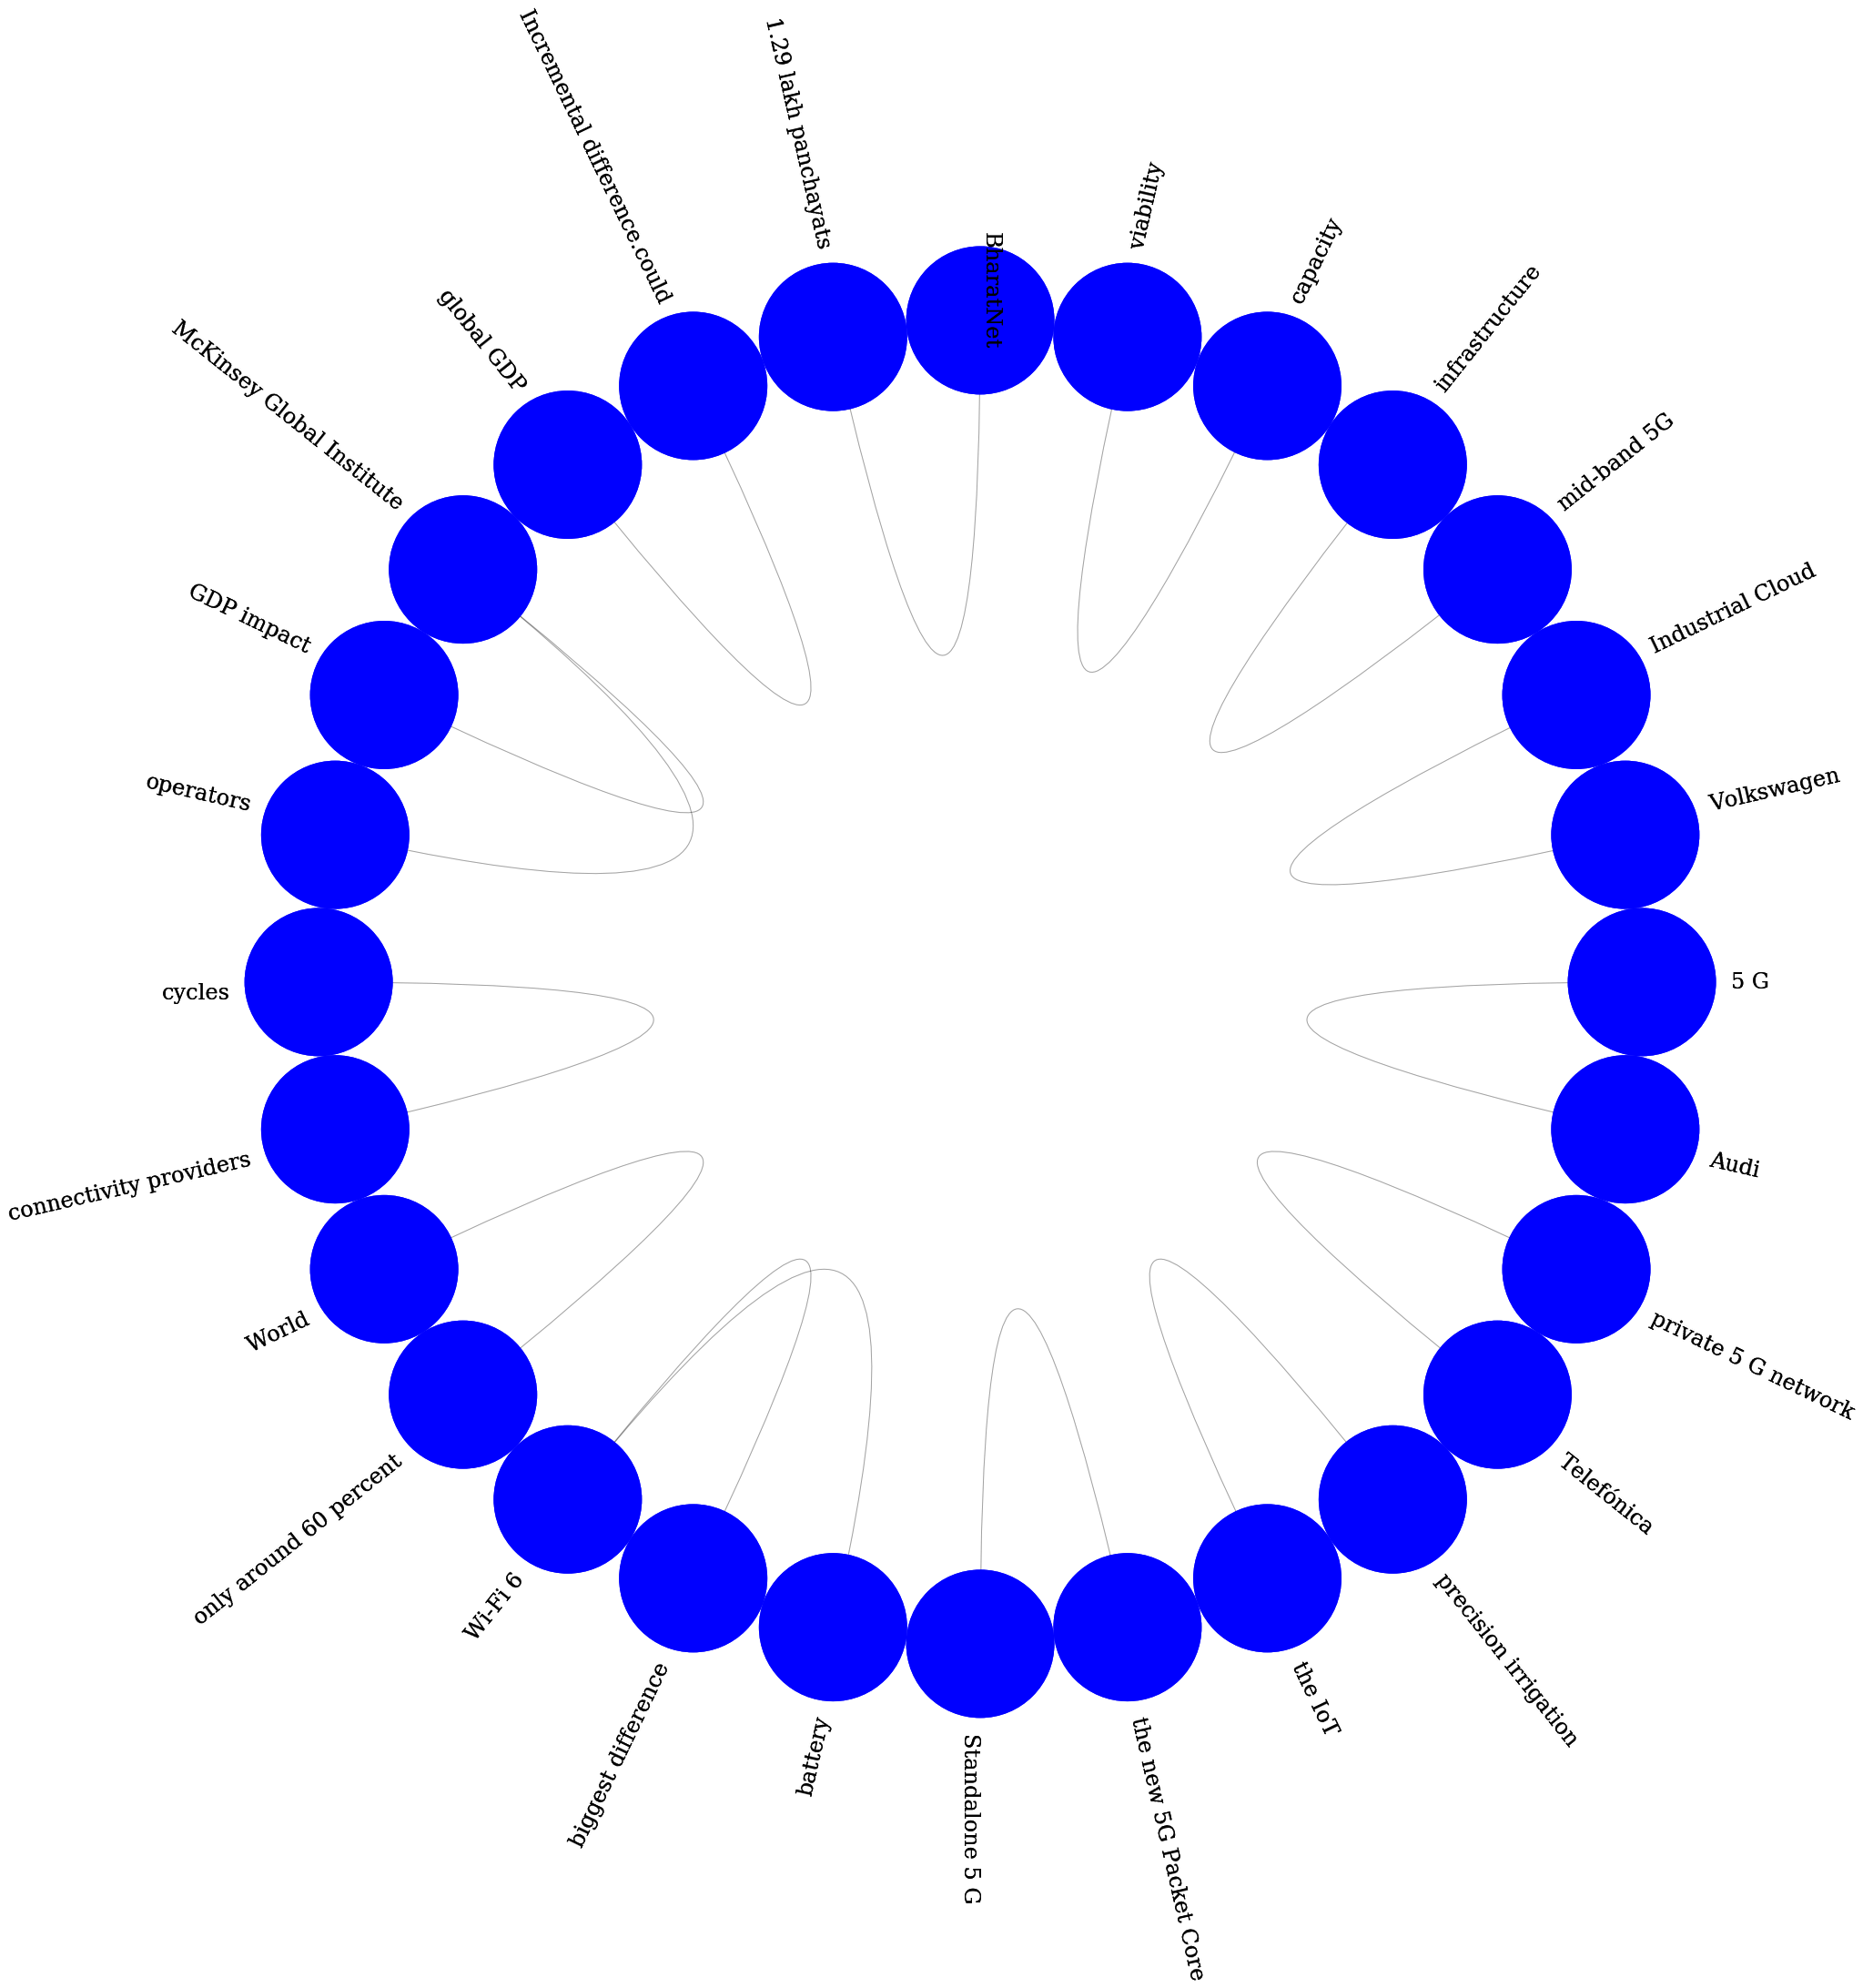

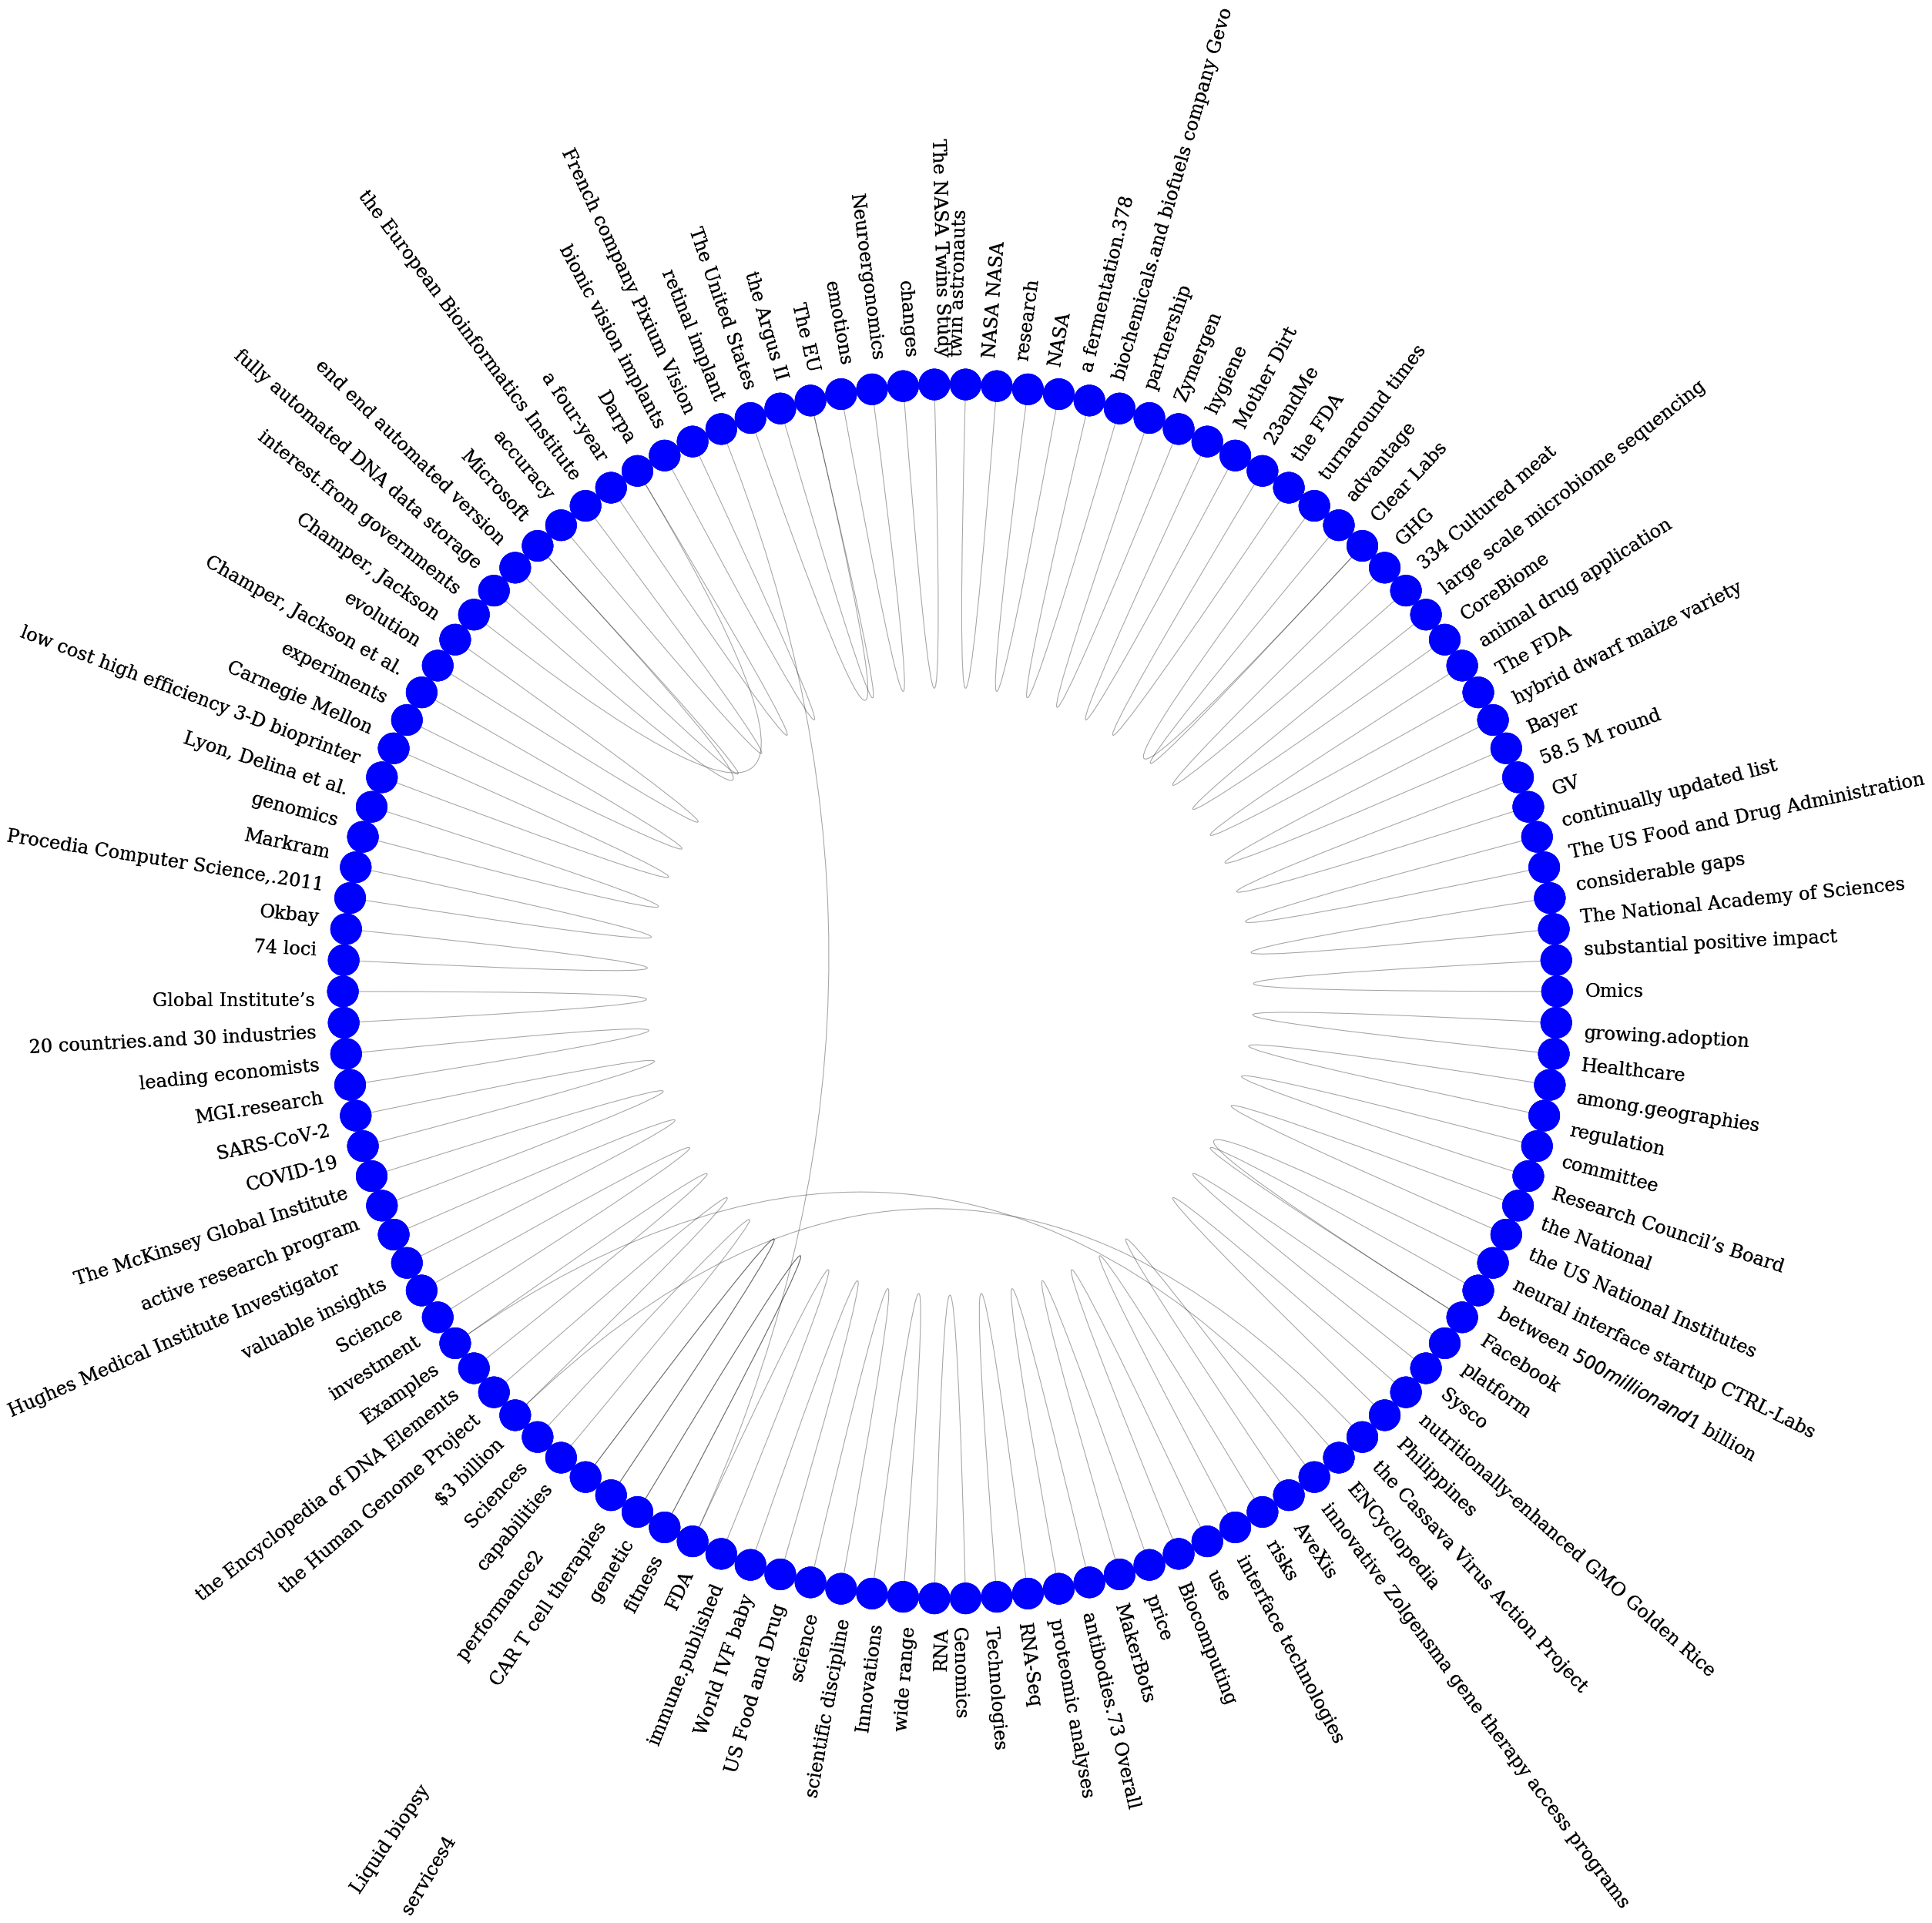

In [18]:
for i in range(len(org_list)):
    circos_plot(org_list[i])

In [29]:
gpe_climate

subject    relation                     object subject_type  \
96                 group    includes            the Philippines   NOUN_CHUNK   
98                 group    includes                   Colombia   NOUN_CHUNK   
100                group    includes                    Germany   NOUN_CHUNK   
102             Examples     include                  Argentina   NOUN_CHUNK   
161  rising temperatures      impact                      India   NOUN_CHUNK   
187                India         has                  potential          GPE   
205     Hurricane Harvey       Texas                    Houston        EVENT   
254                China         see            expected yields          GPE   
262                group    includes            the Philippines   NOUN_CHUNK   
263                group    includes                   Colombia   NOUN_CHUNK   
264                group    includes                      Egypt   NOUN_CHUNK   
267                group    includes                    Germany   NOUN_CHUNK   
268             Examples     include                  Argentina   NOUN_CHUNK   
274           Bangladesh        have  relatively low GDP levels          GPE   
282               Quebec  prohibited                   building          GPE   
284               Canada       tries           forceful message          GPE   

    object_type  
96          GPE  
98          GPE  
100         GPE  
102         GPE  
161         GPE  
187  NOUN_CHUNK  
205         GPE  
254  NOUN_CHUNK  
262         GPE  
263         GPE  
264         GPE  
267         GPE  
268         GPE  
274  NOUN_CHUNK  
282  NOUN_CHUNK  
284  NOUN_CHUNK

In [30]:
gpe_social

subject         relation                               object  \
15             research           covers                            Australia   
64                Japan             lack                               access   
65                 lack            means                                Japan   
71                  set         includes                                Japan   
81            Countries          include                            Australia   
127             Germany       introduced                   sickness insurance   
136              Greece  employment rate                               lowest   
137              Norway              had                          high levels   
144             Finland           bucked                                trend   
148              Sample            omits                               Canada   
162           Australia         followed                      aggregate trend   
191           Australia              saw                               change   
192             Austria              had                        highest share   
210             Germany        underwent          major product market reform   
216         South Korea         reflects        national consumer price index   
229         New Zealand              saw                     largest increase   
230      United Kingdom              saw                     largest increase   
231  the United Kingdom        increased      maximum university tuition fees   
232               Spain           passed                             measures   
251           Australia        tightened                            targeting   
256             Denmark              saw               double digit increases   
260               Spain              has  defined contribution pension assets   
261             Austria           closed     net pension replacement rate gap   
265    2000.236 Denmark             seen                             increase   
275             America            saves                                 2019   
312              Sweden       prioritize                             equality   
313             Austria       constitute                            archetype   
316              Norway           scored                                  134   
318               Italy        witnessed                     notable declines   
320             Ireland            trend               public sector spending   
351               Japan      experienced                  substantial decline   
352               Italy      experienced                     largest increase   
353         South Korea              had                        highest share   
373          California           passes     historic gig economy rights bill   
378              Berlin        announced                                  one   
385         South Korea       introduced                             policies   
391       United States         supports                             students   
397       United States             gain                               access   

    subject_type object_type  
15    NOUN_CHUNK         GPE  
64           GPE  NOUN_CHUNK  
65    NOUN_CHUNK         GPE  
71    NOUN_CHUNK         GPE  
81    NOUN_CHUNK         GPE  
127          GPE  NOUN_CHUNK  
136          GPE  NOUN_CHUNK  
137          GPE  NOUN_CHUNK  
144          GPE  NOUN_CHUNK  
148   NOUN_CHUNK         GPE  
162          GPE  NOUN_CHUNK  
191          GPE  NOUN_CHUNK  
192          GPE  NOUN_CHUNK  
210          GPE  NOUN_CHUNK  
216          GPE  NOUN_CHUNK  
229          GPE  NOUN_CHUNK  
230          GPE  NOUN_CHUNK  
231          GPE  NOUN_CHUNK  
232          GPE  NOUN_CHUNK  
251          GPE  NOUN_CHUNK  
256          GPE  NOUN_CHUNK  
260          GPE  NOUN_CHUNK  
261          GPE  NOUN_CHUNK  
265          GPE  NOUN_CHUNK  
275          GPE        DATE  
312          GPE  NOUN_CHUNK  
313          GPE  N

In [31]:
gpe_trade

subject     relation                                object  \
66         the Philippines      leading                                   way   
67                   India     exported                            35 percent   
86              Bangladesh    automates                              textiles   
89                   China    increases                electricity generation   
128                 Mexico        plays                                  type   
130                  trend         lead                                 China   
131        the Philippines         have                         opportunities   
179      the United States    increased                                 share   
210                 Europe     includes                               Austria   
218                 London    Capturing                                 value   
223      the United States    generates                      almost one-third   
258                  China        given                                  rise   
259  Previous MGI research  highlighted                                 China   
260        China consumers       turned                                 China   
262                  India     exported                            35 percent   
266                  China       easing       foreign investment restrictions   
269            China China    financing  infrastructure construction projects   
271                  China     BUILDING                              DOMESTIC   
276                  China       retain                                 types   
278                  Hefei          has                         existing base   
301             Bangladesh    automates                              textiles   
304                  China    increases                electricity generation   
309      The United States    announced              United States withdrawal   
325                Morocco        serve                              European   
328                  China     pursuing                            automation   
459            South Korea         seen             South Korea Japan exports   
474          United States         play                                  role   

    subject_type object_type  
66           GPE  NOUN_CHUNK  
67           GPE     PERCENT  
86           GPE  NOUN_CHUNK  
89           GPE  NOUN_CHUNK  
128          GPE  NOUN_CHUNK  
130   NOUN_CHUNK         GPE  
131          GPE  NOUN_CHUNK  
179          GPE  NOUN_CHUNK  
210          LOC         GPE  
218          GPE  NOUN_CHUNK  
223          GPE    CARDINAL  
258          GPE  NOUN_CHUNK  
259   NOUN_CHUNK         GPE  
260   NOUN_CHUNK         GPE  
262          GPE     PERCENT  
266          GPE  NOUN_CHUNK  
269          GPE  NOUN_CHUNK  
271          GPE  NOUN_CHUNK  
276          GPE  NOUN_CHUNK  
278          GPE  NOUN_CHUNK  
301          GPE  NOUN_CHUNK  
304          GPE  NOUN_CHUNK  
309          GPE  NOUN_CHUNK  
325          GPE        NORP  
328          GPE  NOUN_CHUNK  
459          GPE  NOUN_CHUNK  
474          GPE  NOUN_CHUNK

In [32]:
gpe_connect

subject    relation                        object subject_type  \
11       India  modernized                         India          GPE   
47       China      retain     China India unique status          GPE   
48       China      poured               huge investment          GPE   
49       China    building                      backbone          GPE   
237      China      poured                  huge amounts          GPE   
247      China   deploying                  new networks          GPE   
263  Followers    Trailing  China                  India   NOUN_CHUNK   

    object_type  
11          GPE  
47   NOUN_CHUNK  
48   NOUN_CHUNK  
49   NOUN_CHUNK  
237  NOUN_CHUNK  
247  NOUN_CHUNK  
263         GPE

In [33]:
gpe_jobs

subject      relation  \
39     occupational categories        States   
45                       Japan         faces   
46           the United States          face   
47           the United States  displacement   
48           the United States           has   
49                      Mexico     projected   
90                       China           has   
97                     Britain       smashed   
194    Occupational categories        States   
196    Occupational categories        States   
210                      Japan           has   
211              Arab Emirates         share   
214                      Japan         faces   
217          the United States          face   
218          the United States     projected   
219          the United States           has   
229          the United States         model   
243                    Germany           see   
252                      India           see   
270                      India          type   
276                      India    RHS.Sector   
279                     Mexico    RHS.Sector   
288                  Singapore   implemented   
306                Switzerland           has   
309                South Korea       adopted   
310                South Korea           has   
334                    Walmart          sign   
342  motorbikes).1 Netherlands    authorized   
346                  Singapore         shown   

                                 object subject_type object_type  
39        many Japan China Mexico India   NOUN_CHUNK         GPE  
45                          combination          GPE  NOUN_CHUNK  
46                significant workforce          GPE  NOUN_CHUNK  
47                        future growth          GPE  NOUN_CHUNK  
48                    growing workforce          GPE  NOUN_CHUNK  
49                                 rate          GPE  NOUN_CHUNK  
90                         fewer robots          GPE  NOUN_CHUNK  
97                      automated looms          GPE  NOUN_CHUNK  
194       many Japan China Mexico India   NOUN_CHUNK         GPE  
196       many Japan China Mexico India   NOUN_CHUNK         GPE  
210         higher automation potential          GPE  NOUN_CHUNK  
211                        similarities          GPE  NOUN_CHUNK  
214                         combination          GPE  NOUN_CHUNK  
217  significant workforce displacement          GPE  NOUN_CHUNK  
218                       future growth          GPE  NOUN_CHUNK  
219                   growing workforce          GPE  NOUN_CHUNK  
229                               wages          GPE  NOUN_CHUNK  
243                    decreased demand          GPE  NOUN_CHUNK  
252              largest new demand net          GPE  NOUN_CHUNK  
270                         high demand          GPE  NOUN_CHUNK  
276                               share          GPE  NOUN_CHUNK  
279                               share          GPE  NOUN_CHUNK  
288                     innovative form          GPE  NOUN_CHUNK  
306      robust apprenticeship pipeline          GPE  NOUN_CHUNK  
309                apprenticeship model          GPE  NOUN_CHUNK  
310                                 one          GPE    CARDINAL  
334                               rises          GPE  NOUN_CHUNK  
342            testing monthly payments          GPE  NOUN_CHUNK  
346                         individuals          GPE  NOUN_CHUNK

In [34]:
gpe_bio

subject       relation  \
97   high throughput                  Scientists        deleted   
242                                  Philippines       approves   
285                            the United States  A New Biology   
287                                   Both China       mandated   
288                                        China         issued   
289                            the United States       followed   
292                                        China         issues   
297                                        China      acquiring   
302                                       France            ban   
451                            The United States       approved   

                                     object subject_type object_type  
97         existing memories.(United States   NOUN_CHUNK         GPE  
242  nutritionally-enhanced GMO Golden Rice          GPE         ORG  
285               Coming Biology Revolution          GPE  NOUN_CHUNK  
287                                labeling          GPE  NOUN_CHUNK  
288                  biosafety certificates          GPE  NOUN_CHUNK  
289                                    suit          GPE  NOUN_CHUNK  
292                  biosafety certificates          GPE  NOUN_CHUNK  
297                                    data          GPE  NOUN_CHUNK  
302                     DTC genetic testing          GPE  NOUN_CHUNK  
451                                  The EU          GPE         ORG

In [35]:
org_climate

subject     relation  \
2                                                  MGI         have   
5                                             McKinsey    developed   
7                                              Birshan     provided   
8                           Woods Hole Research Center     produced   
9    the University of Oxford’s Environmental Chang...       ensure   
12                                       Organizations      include   
22                                            McKinsey          has   
84                        Intensifying climate.hazards          put   
126                                           Each RCP     predicts   
136                       the US Department of Defense   identified   
222                                biosphere.currently      absorbs   
228                   IHS Markit Economics and Country  changing.in   
234                                               UNEP   identified   
235                                            the GCA   calculated   
236                                            the GCA   identified   
289               The World Climate Research Programme      brought   
293                                           Each RCP     predicts   
325  Estimated work       model multi-member ensemb...       assess   
327                                            Lascell        yield   

                                                object subject_type  \
2                                    MGI senior fellow          ORG   
5    McKinsey global greenhouse gas abatement cost ...          ORG   
7                                       critical input          ORG   
8                                           scientific          ORG   
9                                         impartiality          ORG   
12                                               AECOM   NOUN_CHUNK   
22                                        long history          ORG   
84                                            millions          ORG   
126                             global average.warming          ORG   
136                                     climate change          ORG   
222                           approximately 30 percent          ORG   
228                                  systems framework          ORG   
234                                   adaptation costs          ORG   
235                   necessary adaptation investments          ORG   
236                                         categories          ORG   
289                                     climate models          ORG   
293                                     global average          ORG   
325                             climate change impacts          ORG   
327                                potential yield gap          ORG   

    object_type  
2    NOUN_CHUNK  
5    NOUN_CHUNK  
7    NOUN_CHUNK  
8    NOUN_CHUNK  
9    NOUN_CHUNK  
12          ORG  
22   NOUN_CHUNK  
84     CARDINAL  
126  NOUN_CHUNK  
136  NOUN_CHUNK  
222     PERCENT  
228  NOUN_CHUNK  
234  NOUN_CHUNK  
235  NOUN_CHUNK  
236  NOUN_CHUNK  
289  NOUN_CHUNK  
293  NOUN_CHUNK  
325  NOUN_CHUNK  
327  NOUN_CHUNK

In [45]:
org_trade[:30]

subject        relation  \
10                              digital technologies            hold   
44                                            people             use   
51         innovations                                     intensive   
54                                             Volvo        canceled   
62                                             Volvo  Keith Naughton   
82   .                                     Internet           track   
84                                Australian company        utilizes   
98                                           Spotify      popularize   
101                                        Companies    efficiencies   
141       A.                                  farmer      cultivates   
143       A.                                  farmer             use   
182        innovations                                     intensive   
186                                              WTO         assumed   
191                                      Nearshoring    establishing   
208                    the UN Statistical Commission         revised   
215                                    the Starbucks            have   
231                                 digital services         attract   
232                                           Google          serves   
233                                         Facebook      represents   
250                                       Salesforce          offers   
257                                         Americas      Developing   
274                                           Xiaomi        launched   
275                              Pinecone.91 Foxconn     established   
284                                             Ford        exported   
285                                          Hyundai            cars   
289                                     technologies            have   
293                                Advanced robotics          reduce   
297  .                                     Internet           track   
299                               Australian company        utilizes   
321                                             HSBC    Don Weinland   

                              object subject_type object_type  
10                     possibilities          ORG  NOUN_CHUNK  
44                          Facebook   NOUN_CHUNK         ORG  
51                        processing          ORG  NOUN_CHUNK  
54                             plans          ORG  NOUN_CHUNK  
62                  production plans          ORG  NOUN_CHUNK  
82                         shipments          ORG  NOUN_CHUNK  
84                            Google   NOUN_CHUNK         ORG  
98     streaming subscription models          ORG  NOUN_CHUNK  
101                              end          ORG  NOUN_CHUNK  
141                          bananas          ORG  NOUN_CHUNK  
143             imported fertilizers          ORG  NOUN_CHUNK  
182                       processing          ORG  NOUN_CHUNK  
186                   prominent role          ORG  NOUN_CHUNK  
191     demand focused apparel value          ORG  NOUN_CHUNK  
208  the System of National Accounts          ORG         ORG  
215                             look          ORG  NOUN_CHUNK  
231             hundreds of millions          ORG    CARDINAL  
232                 about 60 percent          ORG     PERCENT  
233                       24 percent          ORG     PERCENT  
250                 Salesforce suite          ORG  NOUN_CHUNK  
257                         Americas          ORG         LOC  
274                   homegrown chip          ORG  NOUN_CHUNK  
275                         new base          ORG  NOUN_CHUNK  
284                          180,000          ORG    CARDINAL  
285                          153,000          ORG    CARDINAL  
289            varied complex effect          ORG  NOUN_CHUNK  
293                       importance          ORG  NOUN_CHUNK  
297                 

In [49]:
org_trade[30:]

subject        relation  \
343  The ‘Chinese Netflix’ iQiyi         gearing   
351                        Tesla     established   
364                      the IoT         improve   
368    McKinsey Global Institute        consider   
369                          EVs          reduce   
380                        Volvo        changing   
383                        Volvo  Keith Naughton   
384                         SMEs            have   
388                       Amazon           hosts   
390                       Lazada          offers   
393                      Zendesk          offers   
395                      Zendesk          serves   
397           Group’s Tata Steel    prioritizing   
401                    Coca-Cola            owns   
402                    Coca-Cola       maximizes   
405                    Starbucks            vary   
412                         HSBC             has   
414                       Global          Offers   
424                       Toyota     introducing   
482                       Amazon       announced   
491    McKinsey Global Institute          mapped   
503                of.e-commerce       translate   
508                     We.which        adopting   
509                          EVs        estimate   
510                     McKinsey        obtained   
512                          EVs          reduce   
515             illustrated user        guide.to   

                                                object subject_type  \
343                                             things          ORG   
351                                              Tesla          ORG   
364                                           shipment          ORG   
368                        specific product categories          ORG   
369                                 1.4 trillion trade          ORG   
380                                    planned exports          ORG   
383                                   production plans          ORG   
384                                  new opportunities          ORG   
388                                      million party          ORG   
390                                        marketplace          ORG   
393                                            package          ORG   
395                                         businesses          ORG   
397                                         automation          ORG   
401                                             brands          ORG   
402                                          potential          ORG   
405                        Starbucks product offerings          ORG   
412                                           presence          ORG   
414  a single                          Global     ...   NOUN_CHUNK   
424                           new manufacturing system          ORG   
482                                          expansion          ORG   
491                                      WIOD industry          ORG   
503                                            savings          ORG   
508                            automation technologies          ORG   
509                                              trade          ORG   
510                                 input output table          ORG   
512                                          oil trade          ORG   
515                                    the World Input   NOUN_CHUNK   

    object_type  
343  NOUN_CHUNK  
351     PRODUCT  
364  NOUN_CHUNK  
368  NOUN_CHUNK  
369  NOUN_CHUNK  
380  NOUN_CHUNK  
383  NOUN_CHUNK  
384  NOUN_CHUNK  
388  NOUN_CHUNK  
390  NOUN_CHUNK  
393  NOUN_CHUNK  
395  NOUN_CHUNK  
397  NOUN_CHUNK  
401  NOUN_CHUNK  
402  NOUN_CHUNK  
405  NOUN_CHUNK  
412  NOUN_CHUNK  
414         ORG  
424  NOUN_CHUNK  
482  NOUN_CHUNK  
491  NOUN_CHUNK  
503  NOUN_CHUNK  
508  NOUN_CHUNK  
509  NOUN_CHUNK  
510  NOUN_CHUNK  
512  NOUN_CHUNK  
515         ORG

In [48]:
org_bio[:30]

subject      relation  \
1                                   Global Institute’s       covered   
3                                   leading economists        advise   
5                                           SARS-CoV-2       causing   
9                        The McKinsey Global Institute  Computer.has   
10         Hughes Medical Institute Investigator             offered   
16                                             Science         needs   
61                                            Examples       include   
77                            the Human Genome Project       an idea   
78                                            Sciences      extended   
86                              performance2                 testing   
87   services4                                     ...       profile   
96                                                 FDA      approved   
98                                      World IVF baby          born   
103                                            science           use   
106                                        Innovations         cover   
110                                                RNA    translated   
111                                       Technologies       include   
124                                 proteomic analyses       require   
129                                          MakerBots         bring   
136                                       Biocomputing      includes   
165                             interface technologies          pose   
171                                             AveXis     announces   
213                                           Examples       include   
225                   the Cassava Virus Action Project      involved   
242                                        Philippines      approves   
243                             performance2                 testing   
244  services4                                     ...       profile   
258                                              Sysco      launched   
274                                           Facebook         spent   
277                                           Facebook      acquires   

                                                object subject_type  \
1                       20 countries.and 30 industries          ORG   
3                                         MGI.research   NOUN_CHUNK   
5                                             COVID‑19          ORG   
9                              active research program          ORG   
10                                   valuable insights          ORG   
16                                          investment          ORG   
61                    the Encyclopedia of DNA Elements   NOUN_CHUNK   
77                                          $3 billion          ORG   
78                                        capabilities          ORG   
86   Liquid biopsy                     CAR T cell t...          ORG   
87                                             fitness          ORG   
96                                    immune.published          ORG   
98                                    US Food and Drug   NOUN_CHUNK   
103                              scientific discipline          ORG   
106                                         wide range          ORG   
110                                           Genomics          ORG   
111                                            RNA-Seq   NOUN_CHUNK   
124                              antibodies.73 Overall   NOUN_CHUNK   
129                                              price          ORG   
136                                                use          ORG   
165                                              risks          ORG   
171  innovative Zolgensma gene therapy access programs          ORG   
213                                       ENCyclopedia   NOUN_CHUNK   
225                                         $3 billion          ORG   
242             nutritionally-enhanced 

In [50]:
org_bio[30:]

subject  \
283              the US National Institutes   
284                Research Council’s Board   
286                              regulation   
303                              Healthcare   
312                                   Omics   
313        The National Academy of Sciences   
321     The US Food and Drug Administration   
334                                      GV   
346                                   Bayer   
355                                 The FDA   
359                               CoreBiome   
366                       334 Cultured meat   
369                              Clear Labs   
370                              Clear Labs   
377                                 the FDA   
389                             Mother Dirt   
411                                Zymergen   
413  biochemicals.and biofuels company Gevo   
436                                    NASA   
437                               NASA NASA   
438                    The NASA Twins Study   
443                         Neuroergonomics   
450                                  The EU   
451                       The United States   
456                                     FDA   
470            French company Pixium Vision   
475                                   Darpa   
479   the European Bioinformatics Institute   
483                               Microsoft   
488                               Microsoft   
490                                   Darpa   
505                        Champer, Jackson   
506                 Champer, Jackson et al.   
510                         Carnegie Mellon   
513                     Lyon, Delina et al.   
514                                 Markram   
517                                   Okbay   

                                relation  \
283                                asked   
284                                  set   
286                              differs   
303                               seeing   
312                                 have   
313                               warned   
321                            maintains   
334                                leads   
346                            developed   
355                             approved   
359                               offers   
366                               reduce   
369                               taking   
370                              shorten   
377                              allowed   
389          AOBiome’s consumer division   
411                            announced   
413                           developing   
436                           conducting   
437                             followed   
438                                found   
443                            Interpret   
450                             approved   
451                             approved   
456                    Julie Steenhuysen   
470                    produced.infrared   
475                            announced   
479                             reported   
483                         demonstrated   
488                    Jennifer Langston   
490                           attracting   
505                             Cheating   
506                                drive   
510                           F.Feinberg   
513                                Using   
514  Introducing the Human Brain Project   
517                           identifies   

                                      object subject_type object_type  
283                             the National          ORG         ORG  
284                                committee          ORG  NOUN_CHUNK  
286                        among.geographies   NOUN_CHUNK         ORG  
303                         growing.adoption          ORG  NOUN_CHUNK  
312              substantial positive impact          ORG  NOUN_CHUNK  
313                        considerable gaps          ORG  NOUN_CHUNK  
321                 continually updated list          ORG  NOUN_CHUNK  


In [38]:
org_jobs

subject  \
0                                 Institute   
28                McKinsey Global Institute   
93                             technologies   
251                              the United   
292             The US High School Movement   
293             The US High School Movement   
296                             the GI Bill   
298     Exhibit 28.The High School Movement   
299                               Starbucks   
301                       Markle Foundation   
335                       Danielle Paquette   
356                                  review   
359   latest automation and AI technologies   
382                                 The GGM   
389                          neural network   
396                                    NBER   
398  The Review of Economics and Statistics   
399                      McKinsey & Company   
402               Houghton Mifflin Harcourt   

                                              relation  \
0                                               ranked   
28                                               shift   
93                                                give   
251                                              needs   
292                                             raised   
293                                          propelled   
296                                            changed   
298                                             raised   
299                                                has   
301                                              begun   
335  ‘Look, I can quit’: Why Target is giving worke...   
356                                              shows   
359                                               have   
382                                               uses   
389                                           achieved   
396                                            working   
398                                              issue   
399                                            Gaining   
402                                          Exploring   

                                 object subject_type object_type  
0         the McKinsey Global Institute   NOUN_CHUNK         ORG  
28                             services          ORG  NOUN_CHUNK  
93                         needed boost          ORG  NOUN_CHUNK  
251                              talent          ORG  NOUN_CHUNK  
292              educational attainment          ORG  NOUN_CHUNK  
293                            progress          ORG  NOUN_CHUNK  
296                         perceptions          ORG  NOUN_CHUNK  
298              education skill levels          ORG  NOUN_CHUNK  
299                         entered.gap          ORG         ORG  
301                          initiative          ORG  NOUN_CHUNK  
335                 The Washington Post       PERSON         ORG  
356                             that AI   NOUN_CHUNK         ORG  
359         strong digital capabilities          ORG  NOUN_CHUNK  
382  inputted unemployment displacement          ORG  NOUN_CHUNK  
389                  84 % correct score          ORG  NOUN_CHUNK  
396                               Autor          ORG  NOUN_CHUNK  
398                                  93          ORG    CARDINAL  
399                            momentum          ORG  NOUN_CHUNK  
402                             effects          ORG  NOUN_CHUNK

In [39]:
org_social

subject      relation  \
0                            Global Institute’s       covered   
7    Previous McKinsey Global Institute reports       include   
22                                       Snower     Exploring   
24                                   Education          paid   
40                                   Healthcare    represents   
42                                         OECD     estimated   
47                                   Healthcare      includes   
53                                  Innovations  democratized   
58                                         OECD       defines   
106                               seminal works       include   
112                                  Education          paid   
157                                        Uber         makes   
193                                  healthcare       Outside   
199                                  Healthcare      includes   
223                                   Eichholtz         shows   
236                                     Academy     providing   
254                                    Bernanke       dispute   
339                              white families         owned   
361                     social                           face   
366                        they.create.294 Dell        offers   
383                                       Tafel      collects   
387                                      Amazon      launched   
388                                   Starbucks      offering   
390                         317 Intesa Sanpaolo      offering   
432                                    The OECD       defines   
435                                    The OECD  standardized   
440                                    The OECD       defines   
441                     equivalized                 expresses   
447                                    The HICP      measures   
449                        consumption segments        follow   
456                                   Broadband      includes   
457            healthcare             insurance        covers   
491                   McKinsey Global Institute       Testing   
496                                      Snower     Exploring   

                                           object subject_type object_type  
0                                    20 countries          ORG  NOUN_CHUNK  
7                                     Urban world   NOUN_CHUNK         ORG  
22                            new social contract          ORG  NOUN_CHUNK  
24                                       holidays          ORG  NOUN_CHUNK  
40                                      9 percent          ORG     PERCENT  
42                          quality price changes          ORG  NOUN_CHUNK  
47                               medical products          ORG  NOUN_CHUNK  
53                                         access          ORG  NOUN_CHUNK  
58                   net pension replacement rate          ORG  NOUN_CHUNK  
106                                  Nemat Shafik   NOUN_CHUNK         ORG  
112                                      holidays          ORG  NOUN_CHUNK  
157                 Uber pain New Yorkers problem          ORG  NOUN_CHUNK  
193                                      big role          ORG  NOUN_CHUNK  
199                              medical products          ORG  NOUN_CHUNK  
223                        significant variations          ORG  NOUN_CHUNK  
236                        free education courses          ORG  NOUN_CHUNK  
254                                Summers theory          ORG  NOUN_CHUNK  
339                                    89 percent          ORG     PERCENT  
361                                  difficulties          ORG  NOUN_CHUNK  
366                                      benefits          ORG  NOUN_CHUNK  
383                                    food items          ORG  NOUN_CHUNK  
387                         virtual health clinic          ORG  NOUN_C

In [40]:
org_connect

subject   relation                  object  \
9                          cycles    leading  connectivity providers   
52                          World      reach  only around 60 percent   
76                        Wi-Fi 6       make      biggest difference   
77                        Wi-Fi 6    extends                 battery   
83                 Standalone 5 G   includes  the new 5G Packet Core   
93                        the IoT    deliver    precision irrigation   
189                    Telefónica       with     private 5 G network   
191                          Audi    release                     5 G   
192                    Volkswagen    release        Industrial Cloud   
240                   mid-band 5G    upgrade          infrastructure   
241                      capacity  determine               viability   
243                     BharatNet      links    1.29 lakh panchayats   
253  Incremental difference.could      boost              global GDP   
274     McKinsey Global Institute  calculate              GDP impact   
283     McKinsey Global Institute        use               operators   

    subject_type object_type  
9            ORG  NOUN_CHUNK  
52           ORG     PERCENT  
76           ORG  NOUN_CHUNK  
77           ORG  NOUN_CHUNK  
83    NOUN_CHUNK         ORG  
93           ORG  NOUN_CHUNK  
189          ORG  NOUN_CHUNK  
191          ORG  NOUN_CHUNK  
192          ORG         ORG  
240          ORG  NOUN_CHUNK  
241          ORG  NOUN_CHUNK  
243          ORG  NOUN_CHUNK  
253          ORG  NOUN_CHUNK  
274          ORG  NOUN_CHUNK  
283          ORG  NOUN_CHUNK